# Exploring Station Hierachies in Transitland

Jupyter Notebook: https://willgeary.github.io/transitland_station_hierarchies/

Github repo: https://github.com/willgeary/transitland_station_hierarchies

# Define bounding box around SF and Oakland

Use [bboxfinder](http://bboxfinder.com/) to draw bounding box around SF and Oakland.

In [692]:
%matplotlib inline
import IPython
url = 'http://bboxfinder.com/#37.665070,-122.598983,37.861302,-122.211227'
iframe = '<iframe src=' + url + ' width=100% height=600 frameBorder="0"></iframe>'
IPython.display.HTML(iframe)

# Use Transitland to get all stops within bounding box

Use [Transitland](https://transit.land/) API to get all stop stations within the bounding box.

In [693]:
import requests

In [694]:
%%time

### Inputs ############################################
mapzen_api_key = "mapzen-ai1duha"                    ##
bbox = "-122.598983,37.665070,-122.211227,37.861302" ##
#######################################################

url = "http://transit.land/api/v1/stop_stations?bbox={}&api_key={}&per_page=false&total=true".format(bbox, mapzen_api_key)
print "Querying: ", url
print ""

response = requests.get(url)
json_response = response.json()
print json_response['meta']['total'], "stop_stations in bounding box"
print len(json_response['stop_stations']), "stop_stations in json response"
print ""

Querying:  http://transit.land/api/v1/stop_stations?bbox=-122.598983,37.665070,-122.211227,37.861302&api_key=mapzen-ai1duha&per_page=false&total=true

5669 stop_stations in bounding box
5669 stop_stations in json response
CPU times: user 334 ms, sys: 62.4 ms, total: 396 ms
Wall time: 54 s


# Classify each stop station as either "simple stop" or "station"

The Transitland Stop Stations API includes both "stops" and "stations". Stops are meant to include things like simple bus stops. Stations are meant to refer to larger entities that have multiple platforms.

Stations have some properties that stops don't. They have platforms. They have multiple exits (which are called *egresses* in the Transitland API. Stops don't have any of these things. However, they have been manipulated to conform to the same record format as stations, and thus "fake it" with regard to platforms and egresses. These records have been marked with the property 'generated: true'. So, we know that an entity is a stop, rather than a station, if there are 'generated: true' tags on the egresses or platforms properties.

In [695]:
def classify_stop_station_types(json_input):
    '''If a particular station has all stop egresses and stop platforms with
       generated = true, then it's just a simple stop. Otherwise, its a station.'''
    
    for stop_station in json_input:
        
        generated_or_not_generated = []
        
        for stop_egress in stop_station['stop_egresses']:
            generated_or_not_generated.append(stop_egress['generated'])
        
        for stop_platform in stop_station['stop_platforms']:
            generated_or_not_generated.append(stop_platform['generated'])
        
        if all(generated_or_not_generated):
            stop_station['stop_station_type'] = "Simple Stop"
        else:
            stop_station['stop_station_type'] = "Station"
            
    return json_input

In [703]:
json_data = json_response['stop_stations']
data = classify_stop_station_types(json_data)

# Create unnested dictionary to speed up searches

Keys: onestop_ids for all stations, stops and platforms in the dataset.

Values: entire records from Transitland, including platform records "unnested" from parent station records.

In [704]:
def create_data_dict(data):
    data_dict = {}
    for i in data:
        onestop_id = i['onestop_id']
        data_dict[onestop_id] = i
        if i['stop_station_type'] == 'Station':
            for stop_platform in i['stop_platforms']:
                onestop_id_ = stop_platform['onestop_id']
                data_dict[onestop_id_] = stop_platform
                data_dict[onestop_id_]['stop_station_type'] = 'Stop Platform'
    return data_dict

In [705]:
data_dict = create_data_dict(data)

# Create station hierarchy network

Nodes represent stations, platforms and simple stops. Edges represent station-platform relationships that currently exist in Transitland.

In [699]:
import networkx as nx
import numpy as np

In [700]:
nodes = data_dict.keys()

def get_edges(data):
    '''Get edges from stations to stop_platforms'''
    stations = [i for i in data if i['stop_station_type'] == "Station"]
    edges = []
    for i in stations:
        source = i['onestop_id']
        for stop_platform in i['stop_platforms']:
            target = stop_platform['onestop_id']
            edge = (source, target)
            edges.append(edge)
            
    return edges

edges = get_edges(data)

In [701]:
def make_graph(nodes, edges):
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    return g

In [706]:
g = make_graph(nodes, edges)

print len(g.nodes()), "nodes"
print len(g.edges()), "edges"

5757 nodes
88 edges


# Visualize station hierarchy network

Nodes represent stations, platforms and simple stops. Edges represent station-platform relationships that currently exist in Transitland.

In [131]:
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.offline

In [707]:
def draw_network(g, title, layout=nx.spring_layout, save_to_html = False):
    '''
    Possible layouts:  ['circular_layout', 'random_layout', 'shell_layout', 'spring_layout',
                        'spectral_layout', 'fruchterman_reingold_layout']
    '''
    pos=layout(g)
    
    Xv=[pos[k][0] for k in g.nodes()]
    Yv=[pos[k][1] for k in g.nodes()]
    Xed=[]
    Yed=[]
    for edge in g.edges():
        Xed+=[pos[edge[0]][0],pos[edge[1]][0], None]
        Yed+=[pos[edge[0]][1],pos[edge[1]][1], None] 

    axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
              zeroline=False, showgrid=False, showticklabels=False, title='')
    width=800
    height=800
    layout=Layout(title= title,  
        font= Font(size=12),
        showlegend=False, autosize=False, width=width, height=height, xaxis=XAxis(axis), yaxis=YAxis(axis),          
        margin=Margin(l=40, r=40, b=85, t=100,), hovermode='closest',)

    colors =     {'Simple Stop': '#3186cc', 
                  'Station': '#ff0000',
                  'Stop Platform': '#32CD32', 
                  'Edge': 'rgb(210,210,210)'}
    
    sizes =      {'Simple Stop': 15, 
                  'Station': 100,
                  'Stop Platform': 10, 
                  'Outline': 0.5}
    
    node_colors = [colors[data_dict[i]['stop_station_type']] for i in g.nodes()]
    node_sizes = [sizes[data_dict[i]['stop_station_type']] for i in g.nodes()]
    node_names = [data_dict[i]['name'] for i in g.nodes()]
    
    trace_edges=Scatter(x=Xed, y=Yed, mode='lines', line=Line(color=colors['Edge'], width=1), hoverinfo='none')
    trace_nodes=Scatter(x=Xv, y=Yv, mode='markers', name='net',
                   marker=Marker(symbol='dot', size=sizes, color=node_colors, line=Line(color='rgb(50,50,50)', width=sizes['Outline'])),
                   text=node_names, hoverinfo='text')

    graph_data=Data([trace_edges, trace_nodes])
    figure=Figure(data=graph_data, layout=layout)
    
    # Save to html or display inline
    if save_to_html:
        myChart = plotly.offline.plot(figure,output_type="div", show_link="False",include_plotlyjs="Flase",link_text="")
        with open(save_to_html, "w") as text_file:
            text_file.write(myChart)
    else:
        return py.iplot(figure, filename='Station Hierarchy Network')

In [708]:
%%time

draw_network(g, title="Station Hierarchy Network", save_to_html="../charts/network1.html")

CPU times: user 2min 16s, sys: 1.11 s, total: 2min 17s
Wall time: 2min 20s


In [709]:
url = '../charts/network1.html'
iframe = '<iframe src=' + url + ' width=100% height=800 frameBorder="0"></iframe>'
IPython.display.HTML(iframe)

# Throw it on a map

In [140]:
import folium

In [953]:
def map_network(g, data_dict = data_dict, basemap='Mapbox', save_to_html = False):
    centerLat = np.average([data_dict[i]['geometry']['coordinates'][1] for i in g.nodes()])
    centerLon = np.average([data_dict[i]['geometry']['coordinates'][0] for i in g.nodes()])
    
    # Choose basemap (currently either Mapbox or OSM)
    if basemap == 'Mapbox':
        baseurl = 'http://{s}.tiles.mapbox.com/v4/mapbox.light/{z}/{x}/{y}.png'
        mapbox_api_key = 'pk.eyJ1Ijoid2lsbGdlYXJ5IiwiYSI6ImNpdW9wcmkxNjAxbDUydXQ0MzFwdmdvOWkifQ.9YIdQhYTOpRpocyFK-tBNA'
        token = '?access_token={}'.format(mapbox_api_key)
        m = folium.Map(location=[centerLat, centerLon], zoom_start=13, tiles=baseurl+token, attr='Mapbox')

    elif basemap == 'OSM':
        m = folium.Map(location=[centerLat, centerLon], zoom_start=13)
    
    # Define color scheme
    colors =     {'Simple Stop': '#3186cc', # blue 
                  'Station': '#ff0000', # red
                  'Stop Platform': '#32CD32', # green
                  'Line': '#000000'} # black
    
    sizes =      {'Simple Stop': 5, 
                  'Station': 8,
                  'Stop Platform': 4, 
                  'Outline': 0.5}
    
    # Draw edges
    for i in g.edges():
        source = i[0]
        target = i[1]
        source_name = data_dict[source]['name']
        target_name = data_dict[target]['name']
        source_lat = data_dict[source]['geometry']['coordinates'][1]
        source_lon = data_dict[source]['geometry']['coordinates'][0]
        target_lat = data_dict[target]['geometry']['coordinates'][1]
        target_lon = data_dict[target]['geometry']['coordinates'][0]

        popup_html = folium.Html('<b>Station Name: </b> {} <br> <b>Stop Name: </b> {} <br> <b>Station ID: </b> {} <br> <b>Stop ID: </b> {}'.format(source_name, target_name, source, target), script=True)
        popup = folium.Popup(popup_html, max_width=2650)
        folium.PolyLine(popup=popup, locations=[(source_lat, source_lon), (target_lat, target_lon)], color=colors['Line'], weight=2, opacity=1).add_to(m)

    # Draw nodes  
    for i in g.nodes():

        # Get text for popup
        name = str(data_dict[i]['name']).replace("'",'')
                
        try: 
            operators = data_dict[i]['operators_serving_stop_and_platforms'][0]['operator_name']
        except:
            operators = ""
        stop_station_type = data_dict[i]['stop_station_type']
        try:
            vehicles = ','.join(data_dict[i]['vehicle_types_serving_stop_and_platforms'])
        except:
            vehicles = " "
        location = str(data_dict[i]['geometry']['coordinates'])
        onestop_id = data_dict[i]['onestop_id']

        popup_html = folium.Html("<b>Name: </b> {} <br> <b>Operators: </b> {} <br> <b>Type:</b> {} <br> <b>Vehicles:</b> {} <br> <b>Location:</b> {} <br> <b>Onestop-id:</b> {}".format(name, operators, stop_station_type, vehicles, location, onestop_id), script=True)
        popup = folium.Popup(popup_html, max_width=2650)
        folium.CircleMarker(location=[data_dict[i]['geometry']['coordinates'][1], data_dict[i]['geometry']['coordinates'][0]], radius=sizes[data_dict[i]['stop_station_type']],
                        popup=popup, color=colors[data_dict[i]['stop_station_type']], fill_opacity=0.9,
                        fill_color=colors[data_dict[i]['stop_station_type']]).add_to(m)

    # Optional save map to html
    if save_to_html:
        m.save(save_to_html)
    else:
        return m

In [954]:
%%time

map_network(g, save_to_html="../maps/map9.html")

CPU times: user 4min 30s, sys: 5.66 s, total: 4min 36s
Wall time: 4min 48s


In [980]:
import IPython
url = '../maps/map9.html'
iframe = '<iframe src=' + url + ' width=100% height=600 frameBorder="0"></iframe>'
IPython.display.HTML(iframe)

# Make distance matrix between all stations and simple stops

In [713]:
import pandas as pd
from geopy.distance import vincenty

Note: Can also use API to query within a certain radius: http://transit.land//api/v1/stop_stations?lon=-121.977772198&lat=37.413530093&r=100

In [714]:
def make_distance_matrix(data, data_dict):
    # Get stations and simple stops into separate arrays
    stations = [i for i in data if i['stop_station_type'] == "Station"]
    simple_stops = [i for i in data if i['stop_station_type'] == "Simple Stop"]
    station_ids = [station['onestop_id'] for station in stations]
    simple_stop_ids = [simple_stop['onestop_id'] for simple_stop in simple_stops]
    
    # Initialize empty dataframe to store results
    distance_matrix = pd.DataFrame(index=station_ids, columns=simple_stop_ids)
    
    # Get locations for each station and simple stop pair
    for station in stations:
        station_id = station['onestop_id']
        station_lat = station['geometry']['coordinates'][1]
        station_lon = station['geometry']['coordinates'][0]
        station_location = (station_lat, station_lon)
        
        for simple_stop in simple_stops:
            simple_stop_id = simple_stop['onestop_id']
            simple_stop_lat = simple_stop['geometry']['coordinates'][1]
            simple_stop_lon = simple_stop['geometry']['coordinates'][0]
            simple_stop_location = (simple_stop_lat, simple_stop_lon)
            
            # Calculate distance in meters and store it in matrix
            distance = vincenty(station_location, simple_stop_location).meters
            distance_matrix.loc[station_id][simple_stop_id] = distance
            
    return distance_matrix

In [715]:
%%time

distance_matrix = make_distance_matrix(data, data_dict)

/Users/Will/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



CPU times: user 34.9 s, sys: 443 ms, total: 35.4 s
Wall time: 36.7 s


In [1588]:
distance_matrix.head()

,s-9q9p616uyb-rockridge,s-9q9p1wrwrp-macarthur,s-9q9p1dwqv1-19thstoakland,s-9q9p19uw31-12thstoaklandcitycenter,s-9q9p145u1w-westoakland,s-9q8znb12j1-embarcadero,s-9q8yyxq427-montgomeryst,s-9q8yywd198-powellst,s-9q8yymt18w-civiccenter~unplaza,s-9q8yy6btqm-16thstmission,...,s-9q9p1wxf72-macarthur,s-9q8yyk3eds-missionst~southvannessave,s-9q8yycs1g5-22ndst~pennsylvaniaave,s-9q8yyct493-22ndst~iowast,s-9q8yycw746-22ndst~minnesotast,s-9q8yycxser-3rdst~22ndst,s-9q8yyct4bq-22ndst~iowast,s-9q8yych5sp-pennsylvaniaavenue~23rdstreet,s-9q8yybskfp-pennsylvaniaavenue~25thstreet,s-9q9ngh8rrh-highst~foothillblvd
s-9q9p1dh9te-14thst~broadway,4825.81,2782.97,519.505,51.6462,2091.34,11134.7,11537.7,12226.9,12861.3,13767,...,2782.97,13411.2,11901.4,11793.4,11649.8,11496.8,11793.1,12017.7,12128.5,6211.37
s-9q9p19eumv-11thst~broadway,5092.35,3044.52,784.13,217.288,2026.11,11019.8,11415.6,12095.8,12722.6,13604.3,...,3044.52,13261.5,11712.9,11604.3,11459.7,11306.1,11604.2,11825.4,11932.2,6162.5
s-9q9p19u1u7-12thst~broadway,4987.23,2938.52,680.746,114.335,2035.96,11053.4,11452.3,12136.3,12766.4,13658.4,...,2938.52,13310.1,11778.3,11670,11525.9,11372.5,11669.8,11892.5,12001.2,6192.73
s-9q9p4ckf4b-fruitvaleave~macarthurblvd,5828.7,5501.9,4697.98,4876.92,6966.41,15941.2,16321.2,16976.1,17575.6,18340,...,5501.9,18067.3,16276.6,16164,16012.8,15855.2,16165,16353.4,16420.9,2828.4
s-9q9p4tc63j-highlandave~highlandway,2768.73,3107.09,3703.79,4186.58,5980.15,14951.1,15391.9,16125.2,16796.1,17808.2,...,3107.09,17397.2,16026.7,15920.1,15778.6,15627.1,15919.5,16150.9,16268.8,5841.73


# Get all simple stops within 200 meters of a particular station

In [717]:
def get_nearby_stop_ids(station_id, distance_matrix, radius = 200):
    '''Returns a list of all the onestop-ids within radius of station'''
    
    d = distance_matrix.ix[station_id]
    stop_ids = [d.index[i].values for i in np.where(d < radius)][0]
    
    return stop_ids.tolist()

In [718]:
def get_nearby_stops(station_id, distance_matrix, data, radius = 200):
    '''Returns a list of all the entire records with radius of station'''
    
    stop_ids = get_nearby_stop_ids(station_id, distance_matrix, radius=radius)
    
    stop_records = []
    for stop_id in stop_ids:
        stop_record = filter(lambda i: i['onestop_id'] == stop_id, data['stop_stations'])
        stop_records.append(stop_record[0])
        
    print len(stop_records), "records."
    return stop_records

# Example: 14th St and Broadway AC Transit Station

Here are the four simple stop ids within 200 meters of the 14th St and Broadway AC Transit station:

In [719]:
get_nearby_stop_ids('s-9q9p1dh9te-14thst~broadway', distance_matrix, radius=200)

[u's-9q9p19uw31-12thstoaklandcitycenter',
 u's-9q9p1d5q87-14thst~clayst',
 u's-9q9p19vx61-14thst~franklinst',
 u's-9q9p19vzs8-14thst~franklinst']

Should these four stops be classified as station platforms?

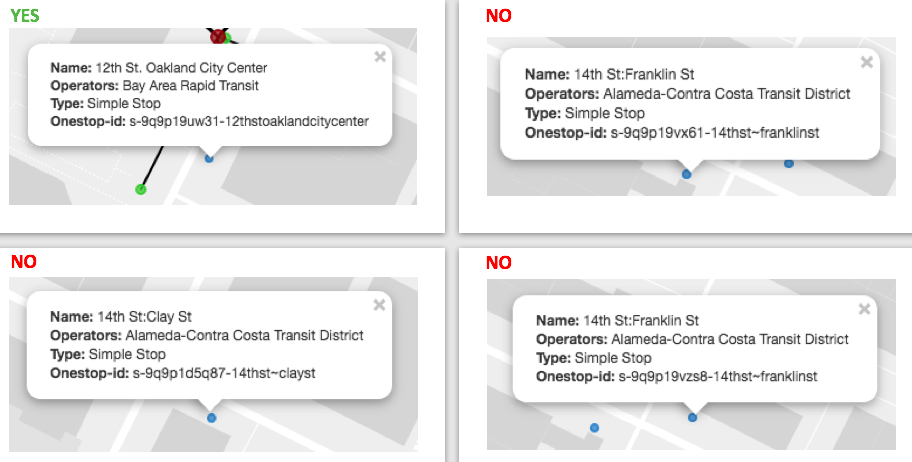

In [720]:
from IPython.display import Image
Image("../images/quadrant.png")

What variables might we want to consider in algorithm:

- Name
- Closeness
- Operators
- Building footprints
- Search radius (vary be station type? vehicle type? station passenger volumn? city density?)
- Edge weights (could be encoded to represent a feature)
- Number of ScheduleStopPairs (SSPs) to gauge a station or stops importance
- Number of existing edges leaving station
- Served by vehicle type:
`
:‘0’ => :‘Tram’,
:‘1’ => :‘Metro’,
:‘2’ => :‘Rail’,
:‘3’ => :‘Bus’,
:‘4’ => :‘Ferry’,
:‘5’ => :‘Cablecar’,
:‘6’ => :‘Gondola’,
:‘7’ => :‘Funicular’,
`

# How will we measure name similarity?

### Fuzzy string matching

In [1474]:
# https://github.com/seatgeek/fuzzywuzzy
from fuzzywuzzy import fuzz

Example string similarity score:

In [1475]:
string1 = "14TH ST. & BROADWAY"
string2 = "12th St. Oakland City Center"
fuzz.token_sort_ratio(string1, string2)/100.0

0.51

This relies on an algorithm called [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance):

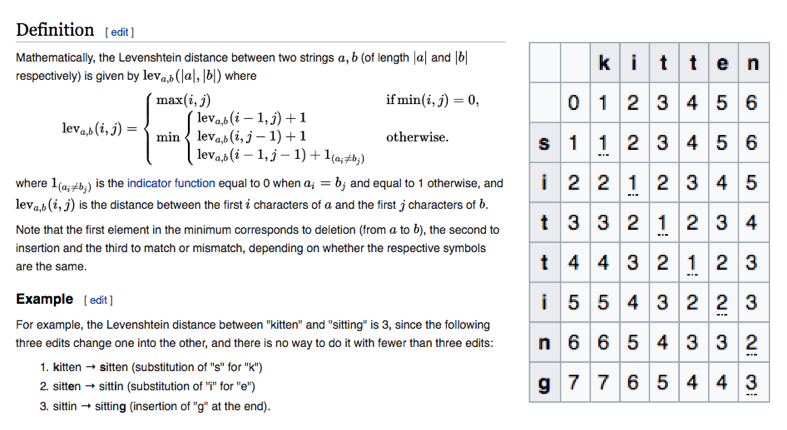

In [723]:
Image("../images/levensthein_smitten_kitten.png")

# How will we measure closeness?

### Inverse log of the distance between stop and station

Here is what all of the distance values look like (unsorted):

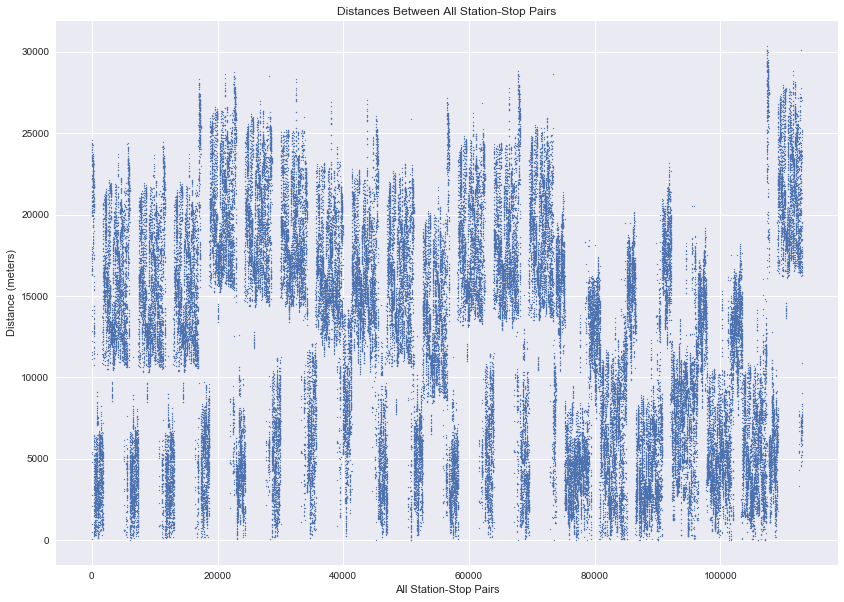

In [1424]:
fig, ax = plt.subplots(figsize=(14, 10))
ax.scatter(range(len(np.ravel(distance_matrix.values))), np.ravel(distance_matrix.values), s=1);
ax.set_ylabel("Distance (meters)")
ax.set_xlabel("All Station-Stop Pairs")
ax.set_title("Distances Between All Station-Stop Pairs");

Here is what all of the distance values look like (sorted):

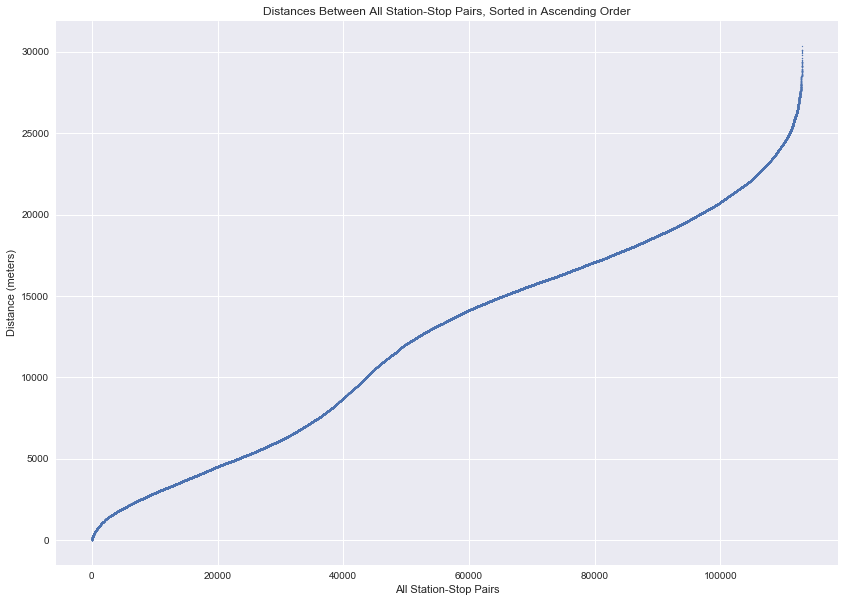

In [1425]:
fig, ax = plt.subplots(figsize=(14, 10))
ax.scatter(range(len(np.ravel(distance_matrix.values))), np.sort(np.ravel(distance_matrix.values)), s=1);
ax.set_ylabel("Distance (meters)")
ax.set_xlabel("All Station-Stop Pairs")
ax.set_title("Distances Between All Station-Stop Pairs, Sorted in Ascending Order");

Here is what a log function looks like:

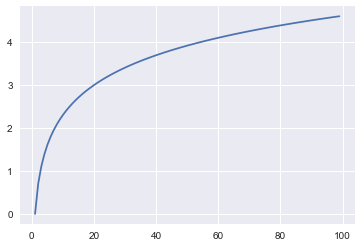

In [1313]:
test_x = np.array(range(1, 100))
test_y = np.log(test_x)
plt.plot(test_x, test_y);

Here is what an inverse log function looks like:

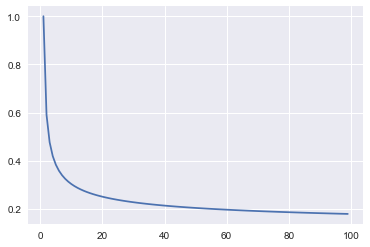

In [1373]:
test_x = np.array(range(1, 100))
test_y = 1 / (1 + np.log(test_x))
plt.plot(test_x, test_y);

Let's use inverse log function to measure closeness.

If we define closeness as:

$$ Closeness = \cfrac{1}{1 + \log (Distance)} $$

In [1426]:
def inverse_log_distance(distance):
    inv_log_dist = (1 / (1 + np.log(distance)))
    return inv_log_dist

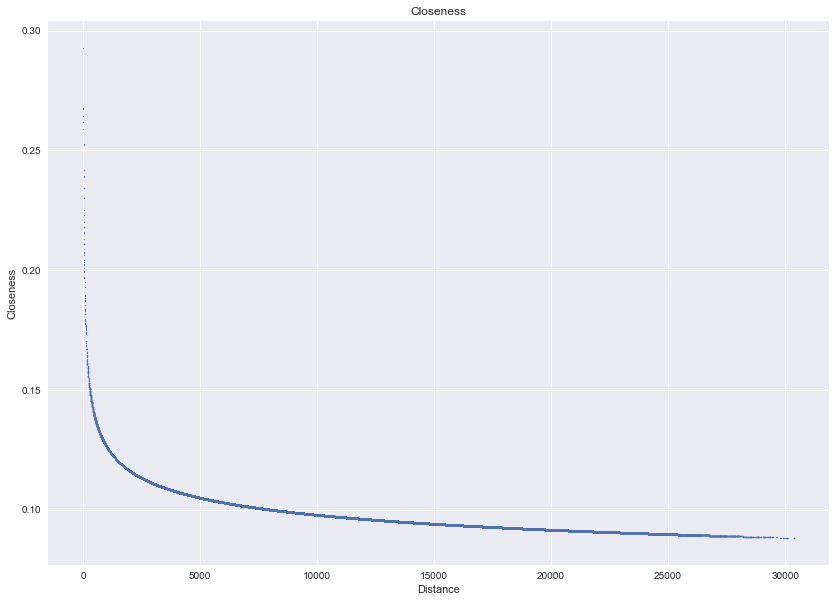

In [1428]:
fig, ax = plt.subplots(figsize=(14, 10))
ax.scatter(sorted(np.ravel(distance_matrix.values)), [inverse_log_distance(i) for i in sorted(np.ravel(distance_matrix.values))], s=1);
ax.set_ylabel('Closeness')
ax.set_xlabel('Distance')
ax.set_title('Closeness');

If we define closeness as:

$$ Closeness = \begin{cases}
               \cfrac{1}{1 + \log(Distance)} & \text{if } Distance < 200 \text{ meters} \\
               0 & \text{otherwise} 
               \end{cases}$$

In [1575]:
def closeness_func(distance):
    
    if distance < 200:
        closeness = (1 / (1 + np.log(distance)))
    else:
        closeness = 0
    
    return closeness

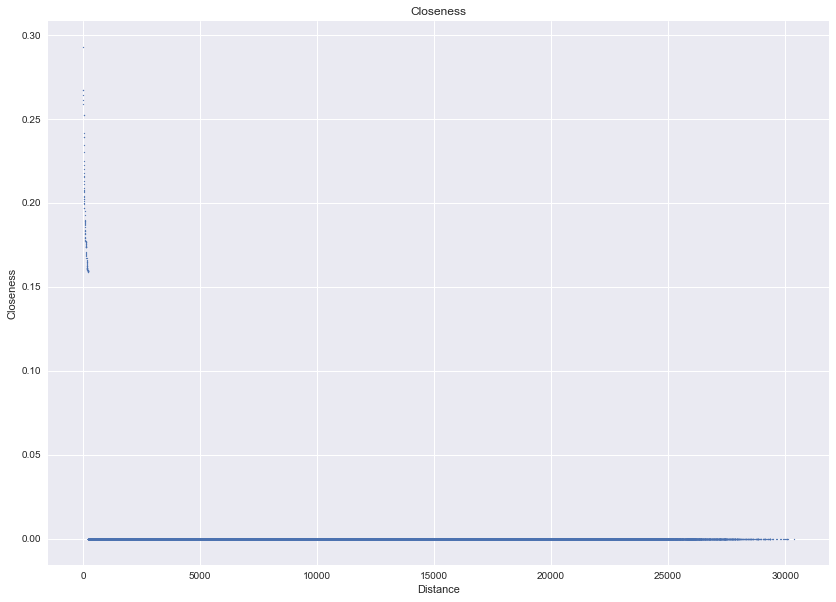

In [1576]:
fig, ax = plt.subplots(figsize=(14, 10))
ax.scatter(sorted(np.ravel(distance_matrix.values)), [closeness_func(i) for i in sorted(np.ravel(distance_matrix.values))], s=1);
ax.set_ylabel('Closeness')
ax.set_xlabel('Distance')
ax.set_title('Closeness');

TODO: Look at all true distances in world to inform our closeness model.

# Get station footprints from Open Street Map

Download all available station footprints in bounding box from OpenStreetMap using Overpass Turbo API so we can make more accurate distance measurements between station polygons and stops.

In [1613]:
def get_station_footprints(bbox):
    '''
    https://overpass-turbo.eu/
    
    ### ORIGINAL QUERY ###
    [out:json][timeout:500];
    (
      way["public_transport"="station"]({{bbox}});
      way["railway"="station"]({{bbox}});
      way["building"="train_station"]({{bbox}});
    );
    out body;
    >;
    out skel qt;
    
    ### STANDALONE QUERY ###
    [out:json][timeout:500];
    (
      way["public_transport"="station"](37.78107755412494,-122.41361618041991,37.79354153685361,-122.39411115646361);
      way["railway"="station"](37.78107755412494,-122.41361618041991,37.79354153685361,-122.39411115646361);
      way["building"="train_station"](37.78107755412494,-122.41361618041991,37.79354153685361,-122.39411115646361);
    );
    out body;
    >;
    out skel qt;
    
    ### OVERPASS API URL ###
    https://overpass-api.de/api/interpreter?data=%5Bout%3Ajson%5D%5Btimeout%3A500%5D%3B%0A%28%0A%20%20way%5B%22public_transport%22%3D%22station%22%5D%2837.78107755412494%2C-122.41361618041991%2C37.79354153685361%2C-122.39411115646361%29%3B%0A%20%20way%5B%22railway%22%3D%22station%22%5D%2837.78107755412494%2C-122.41361618041991%2C37.79354153685361%2C-122.39411115646361%29%3B%0A%20%20way%5B%22building%22%3D%22train_station%22%5D%2837.78107755412494%2C-122.41361618041991%2C37.79354153685361%2C-122.39411115646361%29%3B%0A%29%3B%0Aout%20body%3B%0A%3E%3B%0Aout%20skel%20qt%3B
    '''
    
    url_base = "https://overpass-api.de/api/interpreter?data=%5Bout%3Ajson%5D%5Btimeout%3A500%5D%3B%0A%28%0A%20%20way%5B%22public_transport%22%3D%22station%22%5D%28{}%2C{}%2C{}%2C{}%29%3B%0A%20%20way%5B%22railway%22%3D%22station%22%5D%28{}%2C{}%2C{}%2C{}%29%3B%0A%20%20way%5B%22building%22%3D%22train_station%22%5D%28{}%2C{}%2C{}%2C{}%29%3B%0A%29%3B%0Aout%20body%3B%0A%3E%3B%0Aout%20skel%20qt%3B"
    url = url_base.format(bbox[0],bbox[1],bbox[2],bbox[3], bbox[0],bbox[1], bbox[2], bbox[3], bbox[0],bbox[1],bbox[2],bbox[3])
    print "Querying:", url
    response = requests.get(url)
    data = response.json()
    
    # Get ways
    way_ids = [i['id'] for i in data['elements'] if i['type']=='way']
    way_names = {}
    for i in data['elements']:
        if i['type'] == 'way':
            try:
                way_names[i['id']] = (i['tags']['name'])
            except:
                way_names[i['id']] = "No name found."
    way_nodes = [i['nodes'] for i in data['elements'] if i['type']=='way']
    
    # Make node location dict
    node_locations = {}
    for i in data['elements']:
        try:
            node_locations[i['id']] = [i['lat'], i['lon']]
        except:
            pass
    # Make way polygon dict    
    way_polygons = {}
    for i in data['elements']:
        if i['type'] == 'way':
            way_nodes = i['nodes']
            polygon = []
            for n in way_nodes:
                polygon.append(node_locations[n])
            way_polygons[i['id']] = {'name': way_names[i['id']], 'geometry': {'type': 'Polygon', 'coordinates': polygon}}
    
    print ""
    print len(way_polygons), "/", len(stations), "station footprints found."
    return way_polygons

In [1614]:
footprints = get_station_footprints([float(bbox.split(',')[1]), float(bbox.split(',')[0]), float(bbox.split(',')[3]), float(bbox.split(',')[2])])

Querying: https://overpass-api.de/api/interpreter?data=%5Bout%3Ajson%5D%5Btimeout%3A500%5D%3B%0A%28%0A%20%20way%5B%22public_transport%22%3D%22station%22%5D%2837.66507%2C-122.598983%2C37.861302%2C-122.211227%29%3B%0A%20%20way%5B%22railway%22%3D%22station%22%5D%2837.66507%2C-122.598983%2C37.861302%2C-122.211227%29%3B%0A%20%20way%5B%22building%22%3D%22train_station%22%5D%2837.66507%2C-122.598983%2C37.861302%2C-122.211227%29%3B%0A%29%3B%0Aout%20body%3B%0A%3E%3B%0Aout%20skel%20qt%3B

14 / 20 station footprints found.


TODO: Incorporate station footprint polygons into distance matrix calculations.

# Make similarity matrix

In [1382]:
def make_similarity_matrix(data, distance_matrix, data_dict):
  
    stations = [i for i in data if i['stop_station_type'] == "Station"]
    platforms = [i for i in data for stop_platform in i['stop_platforms'] if stop_platform['generated'] == False]
    simple_stops = [i for i in data if i['stop_station_type'] == "Simple Stop"]
    
    # Initialize empty dataframe to store results
    station_ids = [station['onestop_id'] for station in stations]
    simple_stop_ids = [simple_stop['onestop_id'] for simple_stop in simple_stops]
    similarity_matrix = pd.DataFrame(index=station_ids, columns=simple_stop_ids)
    
    # Get distance and name similarity between each station and simple stop pair
    for station_id in station_ids:
        station_name = data_dict[station_id]['name']
        station_operator = data_dict[station_id]['operators_serving_stop_and_platforms']
        for simple_stop_id in simple_stop_ids:
            
            # 1) Compare name similarity
            simple_stop_name = data_dict[simple_stop_id]['name']
            name_similarity = fuzz.token_sort_ratio(station_name, simple_stop_name)/100.0
            
            # 2) Calculate closeness
            distance = distance_matrix.loc[station_id][simple_stop_id]
            closeness = closeness_func(distance)
            
            # 3) Compare operators
            simple_stop_operator = data_dict[simple_stop_id]['operators_serving_stop_and_platforms']
            different_operators = True if station_operator != simple_stop_operator else False
            
            # Overall similarity score
            similarity_score = (name_similarity * 0.1) + (closeness * 0.8) + (different_operators * 0.1)
            
            # Store results in matrix
            similarity_matrix.loc[station_id][simple_stop_id] = similarity_score
            
    return similarity_matrix

In [1383]:
%%time

similarity_matrix = make_similarity_matrix(data, distance_matrix, data_dict)

CPU times: user 56.9 s, sys: 674 ms, total: 57.6 s
Wall time: 59 s


In [1439]:
similarity_matrix

,s-9q9p616uyb-rockridge,s-9q9p1wrwrp-macarthur,s-9q9p1dwqv1-19thstoakland,s-9q9p19uw31-12thstoaklandcitycenter,s-9q9p145u1w-westoakland,s-9q8znb12j1-embarcadero,s-9q8yyxq427-montgomeryst,s-9q8yywd198-powellst,s-9q8yymt18w-civiccenter~unplaza,s-9q8yy6btqm-16thstmission,...,s-9q9p1wxf72-macarthur,s-9q8yyk3eds-missionst~southvannessave,s-9q8yycs1g5-22ndst~pennsylvaniaave,s-9q8yyct493-22ndst~iowast,s-9q8yycw746-22ndst~minnesotast,s-9q8yycxser-3rdst~22ndst,s-9q8yyct4bq-22ndst~iowast,s-9q8yych5sp-pennsylvaniaavenue~23rdstreet,s-9q8yybskfp-pennsylvaniaavenue~25thstreet,s-9q9ngh8rrh-highst~foothillblvd
s-9q9p1dh9te-14thst~broadway,0.124,0.124,0.165,0.312799,0.143,0.13,0.141,0.14,0.127,0.152,...,0.124,0.122,0.13,0.145,0.133,0.14,0.145,0.13,0.134,0.032
s-9q9p19eumv-11thst~broadway,0.124,0.124,0.165,0.276368,0.143,0.13,0.141,0.14,0.127,0.152,...,0.124,0.122,0.13,0.145,0.133,0.14,0.145,0.13,0.134,0.032
s-9q9p19u1u7-12thst~broadway,0.124,0.124,0.165,0.295394,0.143,0.13,0.141,0.14,0.127,0.152,...,0.124,0.122,0.135,0.152,0.139,0.147,0.152,0.134,0.138,0.032
s-9q9p4ckf4b-fruitvaleave~macarthurblvd,0.116,0.149,0.123,0.129,0.13,0.131,0.12,0.127,0.133,0.119,...,0.149,0.132,0.138,0.128,0.129,0.129,0.128,0.137,0.137,0.041
s-9q9p4tc63j-highlandave~highlandway,0.118,0.118,0.135,0.135,0.138,0.122,0.116,0.124,0.13,0.125,...,0.118,0.137,0.141,0.13,0.127,0.126,0.13,0.136,0.136,0.048
s-9q9nfsy2v8-fruitvalebartstation,0.126,0.126,0.138,0.141,0.129,0.136,0.129,0.126,0.133,0.138,...,0.126,0.135,0.13,0.138,0.138,0.133,0.138,0.134,0.134,0.037
s-9q9nf1t3th-parkst~otisdr,0.125,0.125,0.147,0.143,0.144,0.123,0.143,0.133,0.139,0.14,...,0.125,0.132,0.141,0.147,0.146,0.148,0.147,0.135,0.13,0.05
s-9q9n9vxwbh-harborbayferryterminal,0.124,0.129,0.12,0.131,0.122,0.133,0.126,0.118,0.126,0.125,...,0.129,0.13,0.129,0.12,0.122,0.126,0.12,0.129,0.129,0.03
s-9q9p1qzn8j-40thst~sanpabloave,0.107,0.12,0.156,0.15,0.142,0.119,0.129,0.133,0.138,0.144,...,0.12,0.14,0.153,0.139,0.139,0.134,0.139,0.146,0.154,0.033
s-9q9p145svu-westoaklandbartstation,0.129,0.118,0.16,0.15,0.339457,0.133,0.137,0.129,0.126,0.145,...,0.118,0.137,0.137,0.145,0.144,0.141,0.145,0.139,0.139,0.039


# Visualize similarity heatmap

In [1385]:
def reindex_matrix(similarity_matrix):
    '''Reindexes row and column names for heatmap viz'''
    plotdata = similarity_matrix.copy()
    plotdata.reset_index(inplace=True, drop=True)
    plotdata.columns = range(len(plotdata.columns))
    return plotdata

def similarity_heatmap(similarity_matrix, title='Similarity Matrix', filename='heatmap1'):
    '''Creates heatmap from the reindexed similarity matrix'''
    plotdata = reindex_matrix(similarity_matrix)
    
    data = [Heatmap(
        z = plotdata.values.tolist(), #zmin = 0, #zmax = 1,
        colorscale ='Viridis')]
    
    layout=Layout(
        title = title,
        xaxis = {'title':'Simple Stops'},
        yaxis = {'title':'Stations'})
    
    figure= Figure(data=data,layout=layout)
    return py.iplot(figure, filename=filename)

In [1386]:
def get_score(station_number, stop_number, similarity_matrix):
    rows_dict = dict(zip(range(similarity_matrix.shape[0]), list(similarity_matrix.index)))
    cols_dict = dict(zip(range(similarity_matrix.shape[1]), list(similarity_matrix.columns)))
    row_id = rows_dict[station_number]
    col_id = cols_dict[stop_number]
    score = similarity_matrix.ix[row_id][col_id]
    return score

In [1617]:
def compare_records(station_number, stop_number, similarity_matrix=similarity_matrix, data_dict=data_dict):
    rows_dict = dict(zip(range(similarity_matrix.shape[0]), list(similarity_matrix.index)))
    cols_dict = dict(zip(range(similarity_matrix.shape[1]), list(similarity_matrix.columns)))
    row_id = rows_dict[station_number]
    col_id = cols_dict[stop_number]
    station_record = data_dict[row_id]
    simple_stop_record = data_dict[col_id]
    
    print "#### Station Record ####"
    print 'Name:', station_record['name']
    print 'Operators:', station_record['operators_serving_stop_and_platforms'][0]['operator_name']
    print 'Served by:', station_record['vehicle_types_serving_stop_and_platforms']
    print 'Onestop-id:', station_record['onestop_id']
    print 'Long, Lat:', station_record['geometry']['coordinates']
    print ""
    print "#### Simple Stop Record ####"
    print 'Name:', simple_stop_record['name']
    print 'Operators:', simple_stop_record['operators_serving_stop_and_platforms'][0]['operator_name']
    print 'Served by:', simple_stop_record['vehicle_types_serving_stop_and_platforms']
    print 'Onestop-id:', simple_stop_record['onestop_id']
    print 'Long, Lat:', simple_stop_record['geometry']['coordinates']
    print ""   
    print "#### Similarity Score ####"
    print 'Similarity Score:', get_score(station_number, stop_number, similarity_matrix)
    print 'Distance:', distance_matrix.ix[station_record['onestop_id']][simple_stop_record['onestop_id']], "meters"
    
    return [simple_stop_record['geometry']['coordinates'], station_record['geometry']['coordinates']]

In [1388]:
%%time

similarity_heatmap(similarity_matrix)

CPU times: user 1.47 s, sys: 65 ms, total: 1.54 s
Wall time: 5.72 s


In [1649]:
# use this: comparison = compare_records(13,10)

compare_records(8, 5553)

#### Station Record ####
Name: 40TH ST. & SAN PABLO AVE.
Operators: Alameda-Contra Costa Transit District
Served by: [u'bus']
Onestop-id: s-9q9p1qzn8j-40thst~sanpabloave
Long, Lat: [-122.279198, 37.831195]

#### Simple Stop Record ####
Name: 40th at San Pablo
Operators: Emery Go-Round
Served by: [u'bus']
Onestop-id: s-9q9p1qyz5e-40thatsanpablo
Long, Lat: [-122.279397282198, 37.8312685253329]

#### Similarity Score ####
Similarity Score: 0.385886326553
Distance: 19.348714189 meters


[[-122.279397282198, 37.8312685253329], [-122.279198, 37.831195]]

# View satellite imagery

In [1635]:
import cesiumpy
%matplotlib inline

def fly_to_point(comparison, terrain = False):
    if terrain == True:
        url = '//assets.agi.com/stk-terrain/world'
        terrainProvider = cesiumpy.CesiumTerrainProvider(url=url)
        v = cesiumpy.Viewer(terrainProvider=terrainProvider)
    else:
        v = cesiumpy.Viewer()
        v.camera.flyTo((comparison[0][0], comparison[0][1], 200))
    
    stop_pin = cesiumpy.Pin.fromText('STOP', color=cesiumpy.color.BLUE)
    stop_bill = cesiumpy.Billboard(position=[comparison[0][0], comparison[0][1]], image=stop_pin)
    station_pin = cesiumpy.Pin.fromText('STAT', color=cesiumpy.color.RED)
    station_bill = cesiumpy.Billboard(position=[comparison[1][0], comparison[1][1]], image=station_pin)
    v.entities.add(stop_bill)
    v.entities.add(station_bill)
    
    return v

In [ ]:
fly_to_point(comparison)

Here is a scatter plot of all the similarity scores:

In [1639]:
def plot_similarity_scores(similarity_matrix = similarity_matrix):
    x = []
    for i in similarity_matrix.values:
        for j in i:
            x.append(j)
            
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.scatter(range(len(x)), x)
    ax.set_title("Scatter Plot of Similarity Scores")
    ax.set_ylabel("Similarity Score")
    ax.set_xlabel("Every Station-Stop Pair")
    horizline = 0.25
    ax.axhline(y=horizline, color='r', linestyle='-')
    ax.text(-11.0, horizline+0.01, r'Lazy Classifier: Similarity Score > 0.25', size=16, ha='left', va='center', color='red')

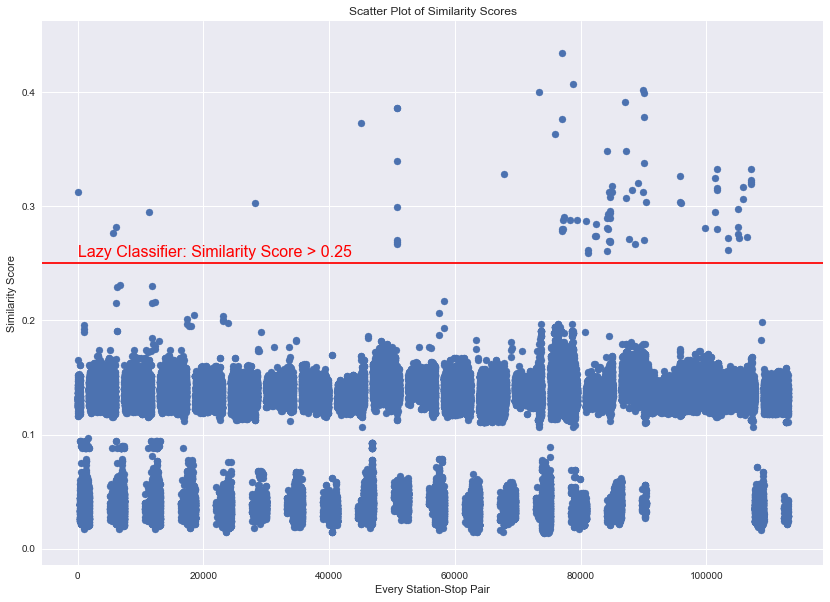

In [1640]:
plot_similarity_scores()

In [ ]:
# other noteworthy comparisons
compare_results(4, 1376)
compare_results(18, 5385)
compare_results(15, 5364)
compare_results(18, 5476)
compare_results(8, 5553)

# We need to label our training data!

# Get all possible edges where source->target are within 200 meters

In [735]:
import pandas as pd

Google sheet from Ian (all stop stations served by rail + potential edges within 200 meters):

In [736]:
# Copy and paste entire sheet: https://docs.google.com/spreadsheets/d/1bcfFH-fHUwlSsLRaRWNI8wIjjGAfWwTJyvKW3Lqmv-c/edit?ts=5951568d#gid=0
df = pd.read_clipboard()

In [737]:
df.head()

,Station,Stop,Operator,Name,Distance,Route,SSPs,Merge?,Parent ID
0,s-9q8ymhqbcv-colma,s-9q8ymhqf6d-colmabart~bay6,o-9q8-samtrans,colma bart-bay 6,26.957863,1,172,Yes,s-9q8ymhqbcv-colma
1,s-9q8ymhqbcv-colma,s-9q8ymhr0g8-colmabart~bay5,o-9q8-samtrans,colma bart-bay 5,36.831951,1,177,Yes,s-9q8ymhqbcv-colma
2,s-9q8ymhqbcv-colma,s-9q8ymhr1u5-colmabart~bay11,o-9q8-samtrans,colma bart-bay 11,41.959033,1,179,Yes,s-9q8ymhqbcv-colma
3,s-9q8ymhqbcv-colma,s-9q8ymhqghh-colmabart~bay12,o-9q8-samtrans,colma bart-bay 12,42.928635,1,60,Yes,s-9q8ymhqbcv-colma
4,s-9q8ymhqbcv-colma,s-9q8ymhqejn-colmabart~bay7,o-9q8-samtrans,colma bart-bay 7,46.712936,1,0,Yes,s-9q8ymhqbcv-colma


In [773]:
# Check what's missing
print sum([i in data_dict.keys() for i in np.unique(df['Stop'])]), "Stop ID's found."
print len(np.unique(df['Stop'])) - sum([i in data_dict.keys() for i in np.unique(df['Stop'])]), "Stop ID's missing."
print ""
print sum([i in data_dict.keys() for i in np.unique(df['Station'])]), "Station ID's found."
print len(df['Stop']) - sum([i in data_dict.keys() for i in df['Station']]), "Station ID's missing."
print ""

381 Stop ID's found.
0 Stop ID's missing.

44 Station ID's found.
0 Station ID's missing.



In [739]:
# Augment data dictionary with the missing values
def augment_data_dict(df, data_dict, skip_missing = False):
    missing_ids = [i for i in np.unique(df['Stop']) if i not in data_dict.keys()]
    missing_ids = missing_ids + [i for i in np.unique(df['Station']) if i not in data_dict.keys()]
    
    if skip_missing == True:
        pass
    else:
        print "Getting", len(missing_ids), "missing ids."
        for i in missing_ids:
            url = "https://transit.land/api/v1/onestop_id/{}".format(i)
            response = requests.get(url)
            data = response.json()
            data_dict[i] = data
            try:
                for stop_egress in i['stop_egresses']:
                    generated_or_not_generated.append(stop_egress['generated'])
                for stop_platform in i['stop_platforms']:
                    generated_or_not_generated.append(stop_platform['generated'])
                if all(generated_or_not_generated):
                    data_dict[i]['stop_station_type'] = "Simple Stop"
                else:
                    data_dict[i]['stop_station_type'] = "Station"   
            except:
                data_dict[i]['stop_station_type'] = 'Stop Platform'

    return data_dict

In [740]:
data_dict = augment_data_dict(df, data_dict)

Getting 5 missing ids.


# Visualize all possible edges using radius = 200 meters

In [741]:
g2 = make_graph(list(np.unique(df['Station'])) + list(np.unique(df['Stop'])), list(zip(df.Station, df.Stop)))

In [742]:
draw_network(g2, title="All Possible Edges Within 200 Meter Radius", layout=nx.nx_pydot.graphviz_layout, save_to_html="../charts/network2.html")

In [743]:
url = '../charts/network2.html'
iframe = '<iframe src=' + url + ' width=90% height=800 frameBorder="0"></iframe>'
IPython.display.HTML(iframe)

# Which of these edges are not currently present in Transitland?

In [744]:
def get_new_edges(g, g2):
    new_edges = []
    for edge in g2.edges():
        if edge not in g.edges():
            new_edges.append(edge)
    return new_edges

In [774]:
new_edges = get_new_edges(g, g2)

print len(g.edges()), "existing edges."
print len(new_edges), "potential edges."
print len(g.edges()) + len(new_edges), "total edges."

88 existing edges.
453 potential edges.
541 total edges.


# Throw it on a map

In [754]:
def map_all_possible_edges(g, g2, df, data_dict = data_dict, basemap='Mapbox', save_to_html = False):
    centerLat = np.average([data_dict[i]['geometry']['coordinates'][1] for i in df['Station']])
    centerLon = np.average([data_dict[i]['geometry']['coordinates'][0] for i in df['Station']])
    new_edges = get_new_edges(g, g2)
    
    # Choose basemap (currently either Mapbox or OSM)
    if basemap == 'Mapbox':
        baseurl = 'http://{s}.tiles.mapbox.com/v4/mapbox.light/{z}/{x}/{y}.png'
        mapbox_api_key = 'pk.eyJ1Ijoid2lsbGdlYXJ5IiwiYSI6ImNpdW9wcmkxNjAxbDUydXQ0MzFwdmdvOWkifQ.9YIdQhYTOpRpocyFK-tBNA'
        token = '?access_token={}'.format(mapbox_api_key)
        m = folium.Map(location=[centerLat, centerLon], zoom_start=13, tiles=baseurl+token, attr='Mapbox')

    elif basemap == 'OSM':
        m = folium.Map(location=[centerLat, centerLon], zoom_start=13)
        
    # Draw existing edges (Black)
    for i in g.edges():
        source = i[0]
        target = i[1]
        source_name = data_dict[source]['name']
        target_name = data_dict[target]['name']
        source_lat = data_dict[source]['geometry']['coordinates'][1]
        source_lon = data_dict[source]['geometry']['coordinates'][0]
        target_lat = data_dict[target]['geometry']['coordinates'][1]
        target_lon = data_dict[target]['geometry']['coordinates'][0]
        edge_type = "Existing edge"
        
        popup_html = folium.Html('<b>Station Name: </b> {} <br> <b>Stop Name: </b> {} <br> <b>Station ID: </b> {} <br> <b>Stop ID: </b> {} <br> <b>Type: </b> {}'.format(source_name, target_name, source, target, edge_type), script=True)
        popup = folium.Popup(popup_html, max_width=2650)
        folium.PolyLine(popup=popup, locations=[(source_lat, source_lon), (target_lat, target_lon)], color='Black', weight=6, opacity=1).add_to(m)
    
    # Draw new edges (Purple)
    for i in new_edges:
        source = i[0]
        target = i[1]
        source_name = data_dict[source]['name']
        target_name = data_dict[target]['name']
        source_lat = data_dict[source]['geometry']['coordinates'][1]
        source_lon = data_dict[source]['geometry']['coordinates'][0]
        target_lat = data_dict[target]['geometry']['coordinates'][1]
        target_lon = data_dict[target]['geometry']['coordinates'][0]
        edge_type = "Potential edge"
        
        popup_html = folium.Html('<b>Station Name: </b> {} <br> <b>Stop Name: </b> {} <br> <b>Station ID: </b> {} <br> <b>Stop ID: </b> {} <br> <b>Type: </b> {}'.format(source_name, target_name, source, target, edge_type), script=True)
        popup = folium.Popup(popup_html, max_width=2650)
        folium.PolyLine(popup=popup, locations=[(source_lat, source_lon), (target_lat, target_lon)], color='Purple', weight=1, opacity=0.8).add_to(m)
    
    
    # Define point color scheme
    colors = {'Simple Stop': '#3186cc', 
              'Station': '#ef3b2c',
              'Stop Platform': '#32CD32', 
              'Line': '#000000'}
    
    # Draw nodes  
    for i in g2.nodes():
        
        # Get text for popup
        name = data_dict[i]['name']
        try: 
            operators = str(data_dict[i]['operators_serving_stop_and_platforms']['operator_name'][0])
        except:
            operators = " "
        stop_station_type = data_dict[i]['stop_station_type']
        try:
            vehicles = ','.join(data_dict[i]['vehicle_types_serving_stop_and_platforms'])
        except:
            vehicles = " "
        location = str(data_dict[i]['geometry']['coordinates'])
        onestop_id = data_dict[i]['onestop_id']
                
        popup_html = folium.Html("<b>Name: </b> {} <br> <b>Operators: </b> {} <br> <b>Type:</b> {} <br> <b>Vehicles:</b> {} <br> <b>Location:</b> {} <br> <b>Onestop-id:</b> {}".format(name, operators, stop_station_type, vehicles, location, onestop_id), script=True)
        popup = folium.Popup(popup_html, max_width=2650)
        folium.CircleMarker(location=[data_dict[i]['geometry']['coordinates'][1], data_dict[i]['geometry']['coordinates'][0]], radius=4,
                        popup=popup, color=colors[data_dict[i]['stop_station_type']], fill_opacity=0.8,
                        fill_color=colors[data_dict[i]['stop_station_type']]).add_to(m)
    
    # Optional save map to html
    if save_to_html:
        m.save(save_to_html)
    else:
        return m

In [755]:
%%time

map_all_possible_edges(g, g2, df, save_to_html="../maps/potential_map2.html")

CPU times: user 46.8 s, sys: 532 ms, total: 47.4 s
Wall time: 48.3 s


In [1633]:
url = '../maps/potential_map2.html'
iframe = '<iframe src=' + url + ' width=100% height=600 frameBorder="0"></iframe>'
IPython.display.HTML(iframe)

# Next steps...

# Machine learning classification algorithms

Automatically created module for IPython interactive environment


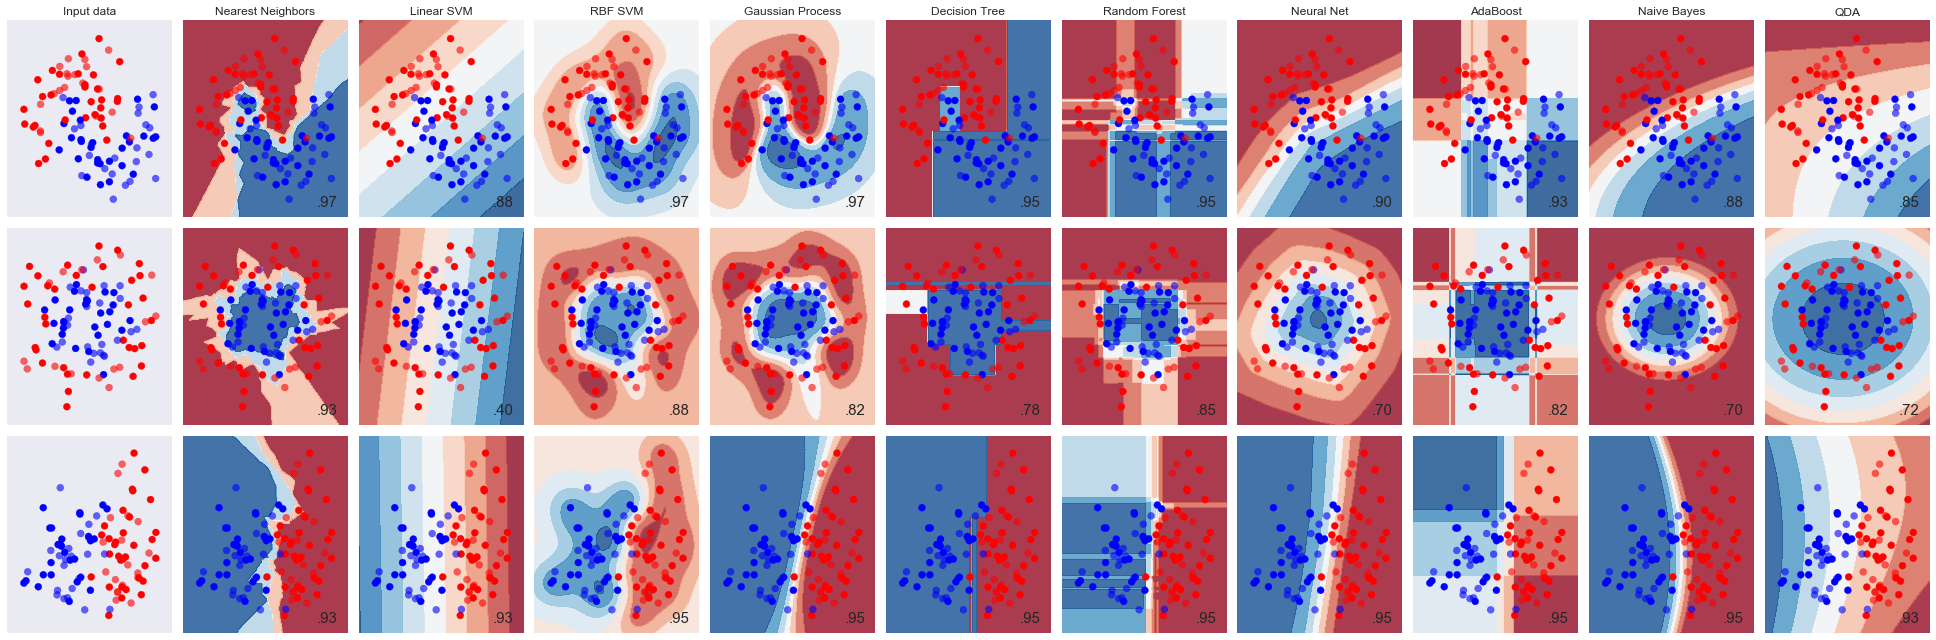

In [1552]:
def show_classifiers():

    print(__doc__)


    # Code source: Gaël Varoquaux
    #              Andreas Müller
    # Modified for documentation by Jaques Grobler
    # License: BSD 3 clause

    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.datasets import make_moons, make_circles, make_classification
    from sklearn.neural_network import MLPClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.svm import SVC
    from sklearn.gaussian_process import GaussianProcessClassifier
    from sklearn.gaussian_process.kernels import RBF
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

    h = .02  # step size in the mesh

    names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
             "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
             "Naive Bayes", "QDA"]

    classifiers = [
        KNeighborsClassifier(3),
        SVC(kernel="linear", C=0.025),
        SVC(gamma=2, C=1),
        GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        MLPClassifier(alpha=1),
        AdaBoostClassifier(),
        GaussianNB(),
        QuadraticDiscriminantAnalysis()]

    X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                               random_state=1, n_clusters_per_class=1)
    rng = np.random.RandomState(2)
    X += 2 * rng.uniform(size=X.shape)
    linearly_separable = (X, y)

    datasets = [make_moons(noise=0.3, random_state=0),
                make_circles(noise=0.2, factor=0.5, random_state=1),
                linearly_separable
                ]

    figure = plt.figure(figsize=(27, 9))
    i = 1
    # iterate over datasets
    for ds_cnt, ds in enumerate(datasets):
        # preprocess dataset, split into training and test part
        X, y = ds
        X = StandardScaler().fit_transform(X)
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=.4, random_state=42)

        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        # just plot the dataset first
        cm = plt.cm.RdBu
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        if ds_cnt == 0:
            ax.set_title("Input data")
        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        i += 1

        # iterate over classifiers
        for name, clf in zip(names, classifiers):
            ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)

            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, x_max]x[y_min, y_max].
            if hasattr(clf, "decision_function"):
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

            # Plot also the training points
            ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
            # and testing points
            ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                       alpha=0.6)

            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())
            ax.set_xticks(())
            ax.set_yticks(())
            if ds_cnt == 0:
                ax.set_title(name)
            ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                    size=15, horizontalalignment='right')
            i += 1

    plt.tight_layout()
    plt.show()
    
show_classifiers()

# Prepare data for classification algorithms

In [849]:
def augment_distance_matrix(df, data, data_dict, distance_matrix):
    # Get stations and simple stops into separate arrays
    stations = [i for i in data if i['stop_station_type'] == "Station"]
    simple_stops = [i for i in data if i['stop_station_type'] == "Simple Stop"]
    station_ids = [station['onestop_id'] for station in stations]
    simple_stop_ids = [simple_stop['onestop_id'] for simple_stop in simple_stops]
    
    missing_station_ids = []
    for i in np.unique(df['Station']):
        if i not in distance_matrix.index:
            missing_stations.append(i)

    missing_stop_ids = []
    for i in np.unique(df['Stop']):
        if i not in distance_matrix.index:
            missing_stations.append(i)
            
    stations += [data_dict[missing_stations_id] for i in missing_station_ids]
    simple_stops += [data_dict[missing_stop_id] for i in missing_stop_ids]
    
    # Initialize empty dataframe to store results
    distance_matrix = pd.DataFrame(index=station_ids, columns=simple_stop_ids)
    
    # Get locations for each station and simple stop pair
    for station in stations:
        station_id = station['onestop_id']
        station_lat = station['geometry']['coordinates'][1]
        station_lon = station['geometry']['coordinates'][0]
        station_location = (station_lat, station_lon)
        
        for simple_stop in simple_stops:
            simple_stop_id = simple_stop['onestop_id']
            simple_stop_lat = simple_stop['geometry']['coordinates'][1]
            simple_stop_lon = simple_stop['geometry']['coordinates'][0]
            simple_stop_location = (simple_stop_lat, simple_stop_lon)
            
            # Calculate distance in meters and store it in matrix
            distance = vincenty(station_location, simple_stop_location).meters
            distance_matrix.loc[station_id][simple_stop_id] = distance
            
    return distance_matrix

In [850]:
distance_matrix_v2 = augment_distance_matrix(df, data, data_dict, distance_matrix)

In [1546]:
import random

# Define features
name_similarity = []
closeness = []
diff_operators = []

# Global variables
stations = [i for i in data if i['stop_station_type'] == "Station"]
platforms = [i for i in data for stop_platform in i['stop_platforms'] if stop_platform['generated'] == False]
simple_stops = [i for i in data if i['stop_station_type'] == "Simple Stop"]
station_ids = [station['onestop_id'] for station in stations]
simple_stop_ids = [simple_stop['onestop_id'] for simple_stop in simple_stops]

for i in g2.edges():
    source = i[0]
    target = i[1]
    
    source_name = data_dict[source]['name']
    target_name = data_dict[target]['name']
    source_id = source
    target_id = source

    # 1) Compare name similarity
    _name_similarity = fuzz.token_sort_ratio(source_name, target_name)/100.0
    
    # 2) Calculate closeness
    
    _closeness = random.uniform(0, 1)

    # 3) Compare operators
    
    try: 
        target_operator = data_dict[target]['operators_serving_stop_and_platforms']
        source_operator = data_dict[source]['operators_serving_stop_and_platforms']
        _different_operators = 1 if source_operator != target_operator else 0
    
    except:
        target_operator = source_operator
        _different_operators = 0
    
    # Store in arrays
    name_similarity.append(_name_similarity)
    closeness.append(_closeness)
    diff_operators.append(_different_operators)

# Our training data will look something like this...

(just dummy data in there now)

In [1646]:
data_dict.keys()

[u's-9q9p68z2vh-broadwayter~glenwoodgladenorthjctn',
 u's-9q9p4te0s0-highlandav~guilfordrdnorthjctn',
 u's-9q9ncfe5n0-otisdr~grandst',
 u's-9q8yuhquut-laplayast~cabrillost',
 u's-9q8ytq2u50-portoladr~dorchesterway',
 u's-9q9p3skq02-martinlutherkingjrway~parkerst',
 u's-9q8yve4f0g-carlst~colest',
 u's-9q8yvdxv9m-rooseveltway~cliffordter',
 u's-9q8yyb121z-evansave~cesarchavezst',
 u's-9q8yvddfzn-colest~almast',
 u's-9q8yteh92n-balboaparkbart~mezzaninelevel',
 u's-9q9p40tu4u-e18thst~8thav',
 u's-9q9p457fgg-macarthurblvd~vanburenav',
 u's-9q8yt2mvkn-missionst~evergreenave~dalycity',
 u's-9q9p4d0d3w-parkblvd~chathamrd',
 u's-9q8ytsv4wq-montereyblvd~ednast',
 u's-9q8yv1p1tj-9thave~noriegast',
 u's-9q9p4075xy-e15thst~7thav',
 u's-9q8yuvxxvm-gearyblvd~17thave',
 u's-9q8ytngj36-15thave~taravalst',
 u's-9q8zpk5w63-treasureislandrd~guardstation',
 u's-9q8ysfmwp9-fontblvd~juanbautisacir',
 u's-9q8yyc01dy-23rdst~wisconsinst',
 u's-9q9p0ts8jz-i~80fwy~tollplazaeastbound',
 u's-9q8yywg39j-marketst~gra

In [1647]:
dta = pd.DataFrame()

dta['edge'] = g2.edges()
dta['name'] = name_similarity
dta['closeness'] = closeness
dta['diff_operators'] = diff_operators

true_edges = []
for i in dta.index:
    if dta['name'].loc[i] > 0.5:
        if dta['diff_operators'].loc[i] == 1:
            true_edges.append(1)
        else:
            true_edges.append(0)
    else:
        true_edges.append(0)

dta['true_edge'] = true_edges

In [1648]:
dta

,edge,name,closeness,diff_operators,true_edge
0,(s-9q9p4yx47p-moragaav~montclairrecreationcent...,0.71,0.675816,0,0
1,"(s-9q8yykbfhf-vannessave~oakst, s-9q8yykc0k8-m...",0.72,0.636726,1,1
2,"(s-9q8ytdv51m-genevaave~sanjoseave, s-9q8ytehd...",0.24,0.067924,1,0
3,"(s-9q9p5n24g6-moragaave~montclairpark, s-9q9p5...",0.32,0.725777,0,0
4,"(s-9q9p5n24g6-moragaave~montclairpark, s-9q9p5...",0.68,0.353630,0,0
5,"(s-9q9p5n24g6-moragaave~montclairpark, s-9q9p5...",0.65,0.347833,0,0
6,"(s-9q9p5n24g6-moragaave~montclairpark, s-9q9p5...",0.61,0.108807,0,0
7,"(s-9q9p5n24g6-moragaave~montclairpark, s-9q9p5...",0.86,0.242278,0,0
8,"(s-9q9p5n24g6-moragaave~montclairpark, s-9q9p5...",0.61,0.800538,0,0
9,"(s-9q8ymhqejn-colmabart~bay7, s-9q8ymhqbcv-colma)",0.48,0.680377,1,0


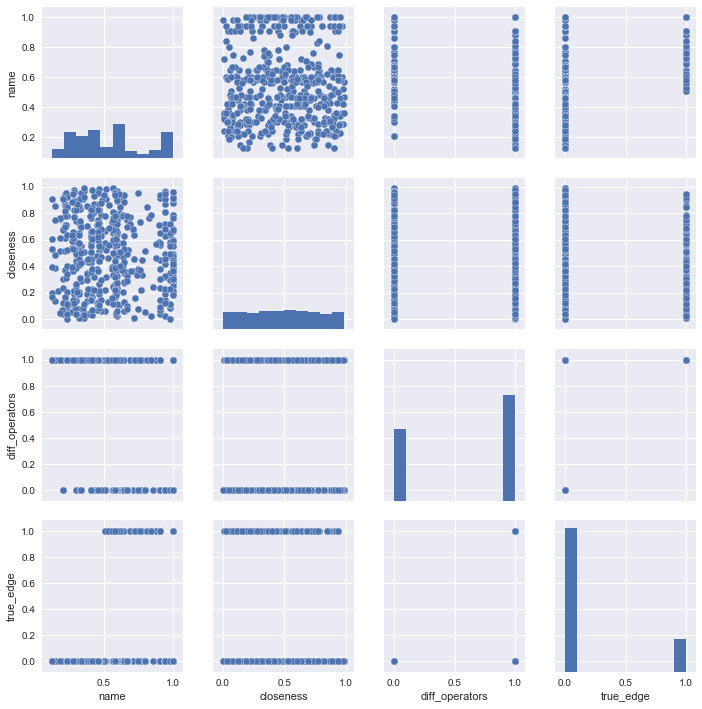

In [1629]:
seaborn.pairplot(dta);

# How will we assess the results?

We want to correctly identify stops that that should be platforms as platforms. But we also want to avoid incorrectly identifying true, simple stops as platforms. 

***Problem:*** there is no perfect way of describing the below "confusion matrix" of true and false positives and negatives with a single number!

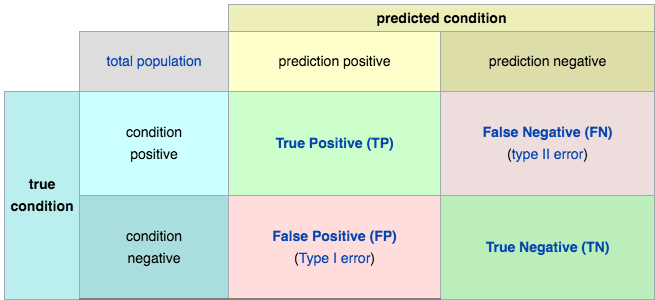

In [1626]:
Image("../images/truth_table.png")

We will rely on two metrics, precision and recall.

$ Precision = \cfrac{\text{# of correct results}}{\text{# of all returned results}}$

$ Recall = \cfrac{\text{# of correct results}}{\text{# of results that should have been returned}}$

We will take the [harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean) of $Precision$ and $Recall$, which is known as the $F_1$ [score](https://en.wikipedia.org/wiki/F1_score), a commonly used measure for a test's accuracy:

$ F_1  = 2 \cdot \cfrac{1}{\cfrac{1}{recall} + \cfrac{1}{precision}} = 2 \cdot \cfrac{precision \cdot recall}{precision + recall} $

We could also consider the [Matthews Correlation Coefficient](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient), which takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes.

$ MCC = \cfrac{TP \cdot TN - FP \cdot FN}{\sqrt{(TP + FP)\ (TP + FN)\ (TN + FP)\ (TN + FN)}}$

In [895]:
#import statsmodels.api as sm
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
import matplotlib.pyplot as plt
import seaborn

Logistic function:

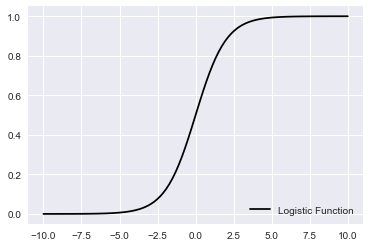

In [854]:
x = np.linspace(-10, 10, 100)
y = 1.0 / (1.0 + np.exp(-x))

plt.plot(x, y, 'black', label='Logistic Function')
plt.legend(loc='lower right');

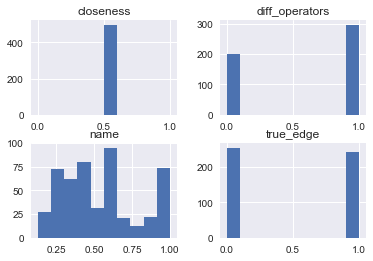

In [855]:
dta.hist(bins=10);

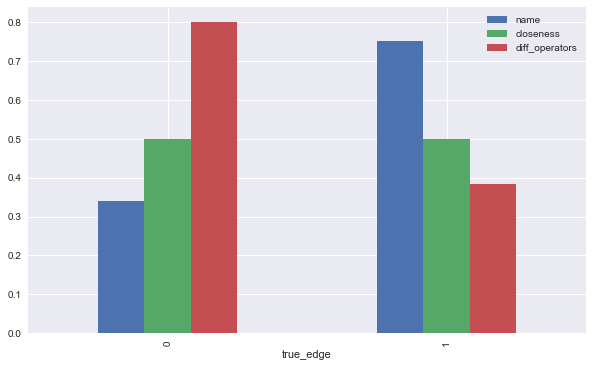

In [856]:
dta.groupby('true_edge').mean().plot(kind='bar', figsize=(10,6));

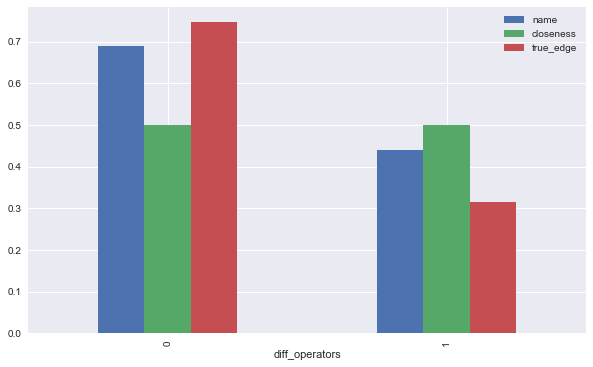

In [857]:
dta.groupby('diff_operators').mean().plot(kind='bar', figsize=(10,6));

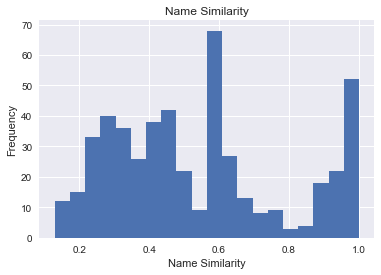

In [858]:
# histogram of name similarity
dta['name'].hist(bins=20)
plt.title('Name Similarity')
plt.xlabel('Name Similarity')
plt.ylabel('Frequency');

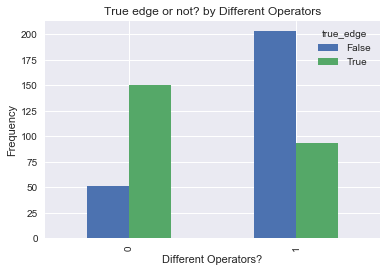

In [859]:
# barplot of true_edge occurences grouped by different operators (True or False)
pd.crosstab(dta['diff_operators'], dta['true_edge'].astype(bool)).plot(kind='bar')
plt.title('True edge or not? by Different Operators')
plt.xlabel('Different Operators?')
plt.ylabel('Frequency');

# Split data into dependent and independent variables

In [1555]:
dta

,edge,name,closeness,diff_operators,true_edge
0,(s-9q9p4yx47p-moragaav~montclairrecreationcent...,0.71,0.675816,0,0
1,"(s-9q8yykbfhf-vannessave~oakst, s-9q8yykc0k8-m...",0.72,0.636726,1,1
2,"(s-9q8ytdv51m-genevaave~sanjoseave, s-9q8ytehd...",0.24,0.067924,1,0
3,"(s-9q9p5n24g6-moragaave~montclairpark, s-9q9p5...",0.32,0.725777,0,0
4,"(s-9q9p5n24g6-moragaave~montclairpark, s-9q9p5...",0.68,0.353630,0,0
5,"(s-9q9p5n24g6-moragaave~montclairpark, s-9q9p5...",0.65,0.347833,0,0
6,"(s-9q9p5n24g6-moragaave~montclairpark, s-9q9p5...",0.61,0.108807,0,0
7,"(s-9q9p5n24g6-moragaave~montclairpark, s-9q9p5...",0.86,0.242278,0,0
8,"(s-9q9p5n24g6-moragaave~montclairpark, s-9q9p5...",0.61,0.800538,0,0
9,"(s-9q8ymhqejn-colmabart~bay7, s-9q8ymhqbcv-colma)",0.48,0.680377,1,0


In [1557]:
# create dataframes with an intercept column and dummy variables diff_operators
y, X = dmatrices('true_edge ~ name + closeness + diff_operators',
                  dta, return_type="dataframe")

In [1558]:
y

,true_edge
0,0.0
1,1.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


In [1559]:
X

,Intercept,name,closeness,diff_operators
0,1.0,0.71,0.675816,0.0
1,1.0,0.72,0.636726,1.0
2,1.0,0.24,0.067924,1.0
3,1.0,0.32,0.725777,0.0
4,1.0,0.68,0.353630,0.0
5,1.0,0.65,0.347833,0.0
6,1.0,0.61,0.108807,0.0
7,1.0,0.86,0.242278,0.0
8,1.0,0.61,0.800538,0.0
9,1.0,0.48,0.680377,1.0


In [1560]:
# flatten y into a 1-D array
y = np.ravel(y)

In [1581]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()

# train the model
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.91348088531187122

In [1582]:
# what percentage are true edges?
y.mean()

0.18511066398390341

In [1583]:
# examine the coefficients
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Intercept,[-3.64532632761]
1,name,[5.34715501011]
2,closeness,[-0.504166473288]
3,diff_operators,[4.14012219645]


# Model Evaluation Using Testing Data

So far, we have trained and tested on the same set. Let's instead split the data into a training set and a testing 

set.

In [1630]:
classifiers = [
        KNeighborsClassifier(3),
        SVC(kernel="linear", C=0.025),
        SVC(gamma=2, C=1), # RBF Kernel
        GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        MLPClassifier(alpha=1),
        AdaBoostClassifier(),
        GaussianNB(),
        LinearDiscriminantAnalysis()]

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
             "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
             "Naive Bayes", "LDA"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

def compare_models_accuracy(classifiers, names):

    classifier_names = dict(zip(classifiers, names))
    classifier_scores = {}

    for i in classifiers:

        model2 = i
        
        # fit the model
        model2.fit(X_train, y_train)

        # predict class labels for the test set
        predicted = model2.predict(X_test)

        # generate class probabilities
        # probs = model2.predict_proba(X_test)

        # generate evaluation metrics
        acc = metrics.accuracy_score(y_test, predicted)
        #roc = metrics.roc_auc_score(y_test, probs[:, 1])

        # store results in dictionary
        classifier_scores[classifier_names[i]] = acc
        
    return classifier_scores

In [1641]:
compare_models_accuracy(classifiers, names)

{'AdaBoost': 1.0,
 'Decision Tree': 1.0,
 'Gaussian Process': 1.0,
 'LDA': 0.93999999999999995,
 'Linear SVM': 0.84666666666666668,
 'Naive Bayes': 0.58666666666666667,
 'Nearest Neighbors': 0.97999999999999998,
 'Neural Net': 0.93999999999999995,
 'RBF SVM': 0.97333333333333338,
 'Random Forest': 1.0}

In [1632]:
print metrics.confusion_matrix(y_test, predicted)

[[127   0]
 [ 23   0]]


In [1573]:
# which features matter?
from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(X_train, y_train)
inds = np.argsort(mi) # returns indices of the feature in the dataset, in an ascending order based on mi values

(0, 4)

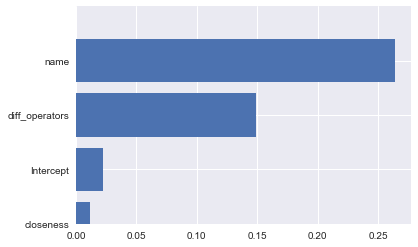

In [1574]:
plt.figure()
plt.barh(np.arange(len(mi)), np.log(mi[inds] + 1))
plt.yticks(np.arange(len(mi)), X_train.columns[inds])
plt.ylim(0, len(mi))

(0, 50)

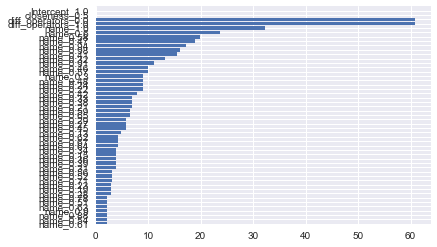

In [839]:
# Using f_regression to discard parameters
# meaning that we use a threshold to discard all features with too high a p-value 
# (which means they are unlikely to be related to the target).

X_train_dummies = pd.get_dummies(X_train, columns=X_train.columns)

from sklearn.feature_selection import f_regression
F, p = f_regression(X_train_dummies, y_train)

top_n = 50
inds = np.argsort(F)
plt.figure()
plt.barh(np.arange(top_n), F[inds[-top_n:]])
plt.yticks(np.arange(top_n), X_train_dummies.columns[inds[-top_n:]])
plt.ylim(0, top_n)

In [840]:
# creating a pipeline using cross validation

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score

cross_val_score(RidgeCV(alphas=np.logspace(-3, 3, 7)), X_train_dummies, y_train, cv=5)

array([ 0.93552261,  0.96139345,  0.98783117,  0.94579762,  0.96076543])

In [841]:
ridge = RidgeCV(alphas=np.logspace(-3, 3, 7)).fit(X_train_dummies, y_train)
ridge.alpha_

0.001

(0, 50)

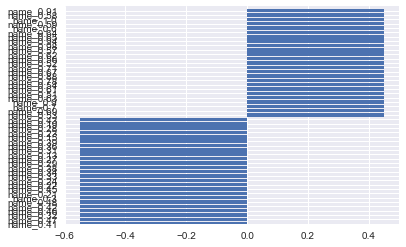

In [842]:
top_n = 50
coef = ridge.coef_
inds = np.argsort(coef)
inds = np.hstack([inds[:top_n // 2], inds[-top_n//2:]])
plt.figure()
plt.barh(np.arange(top_n), coef[inds])
plt.yticks(np.arange(top_n), X_train_dummies.columns[inds])
plt.ylim(0, top_n)

Resources:

* http://nbviewer.jupyter.org/gist/justmarkham/6d5c061ca5aee67c4316471f8c2ae976

* http://nbviewer.jupyter.org/github/moorissa/predictnycrent/blob/master/rent_predictor.ipynb


http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-28.html

https://www.datarobot.com/blog/classification-with-scikit-learn/


# How will we assess the results?

We want to correctly identify stops that that should be platforms as platforms. But we also want to avoid incorrectly identifying true, simple stops as platforms. 

***Problem:*** there is no perfect way of describing the below matrix of true and false positives and negatives with a single number!

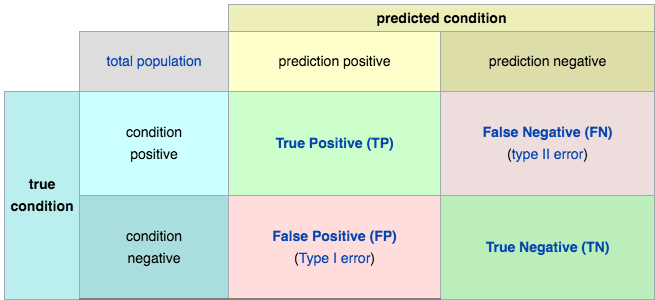

In [1627]:
Image("../images/truth_table.png")

We will rely on two metrics, precision and recall.

$ Precision = \cfrac{\text{# of correct results}}{\text{# of all returned results}}$

$ Recall = \cfrac{\text{# of correct results}}{\text{# of results that should have been returned}}$

We will take the [harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean) of $Precision$ and $Recall$, which is known as the $F_1$ [score](https://en.wikipedia.org/wiki/F1_score), a commonly used measure for a test's accuracy:

$ F_1  = 2 \cdot \cfrac{1}{\cfrac{1}{recall} + \cfrac{1}{precision}} = 2 \cdot \cfrac{precision \cdot recall}{precision + recall} $

We could also consider the [Matthews Correlation Coefficient](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient), which takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes.

$ MCC = \cfrac{TP \cdot TN - FP \cdot FN}{\sqrt{(TP + FP)\ (TP + FN)\ (TN + FP)\ (TN + FN)}}$

# Highest scoring station-stop edges:

Here are the source -> target pairs with the highest score:

In [464]:
def get_top_scores(similarity_matrix, threshold = 0.25):
    scores = pd.DataFrame(similarity_matrix.where(similarity_matrix > threshold).unstack().dropna().sort_values(ascending=False))
    output = pd.DataFrame()
    output['Station'] = [i[1] for i in scores.index]
    output['Stop'] = [i[0] for i in scores.index]
    output['Score'] = scores.values
    print len(output), "edges with score >", threshold
    return output
          

In [465]:
get_top_scores(similarity_matrix)

68 edges with score > 0.25


,Station,Stop,Score
0,s-9q8yy29g1p-24thst~missionst,s-9q8yy29enn-24thst~missionst,0.472366
1,s-9q8yykc0k8-marketst~southvannessave,s-9q8yykc02x-marketst~vannessave,0.422136
2,s-9q8yykc0k8-marketst~southvannessave,s-9q8yykc08d-vannessave~marketst,0.41735
3,s-9q8yy29g1p-24thst~missionst,s-9q8yy29ekt-missionst~24thst,0.414546
4,s-9q8yy29g1p-24thst~missionst,s-9q8yy29dff-24thstmission,0.414393
5,s-9q8yykc0k8-marketst~southvannessave,s-9q8yykc00d-metrovannessstation,0.410792
6,s-9q9p1qzn8j-40thst~sanpabloave,s-9q9p1qznh4-40thatsanpablo,0.396331
7,s-9q9p1qzn8j-40thst~sanpabloave,s-9q9p1qyz5e-40thatsanpablo,0.395785
8,s-9q8yykc0k8-marketst~southvannessave,s-9q8yyk8zxh-marketst~southvannessave,0.382948
9,s-9q8yykc0k8-marketst~southvannessave,s-9q8yykbbww-vannessstationoutbound,0.361209


# Function to generate parameters for simulation

In [386]:
def generate_trials(start=0, stop=1, steps=10):
    x_range = np.linspace(start, stop, steps + 1)
    results = []
    i = 0
    for x in x_range:
        y_range = np.linspace(start, stop-x, steps + 1)
        for y in y_range:
            z = 1 - (x + y)
            results.append({'x': x, 'y': y, 'z': z})
            i += 1
    return results

In [387]:
%%time
x = generate_trials()

CPU times: user 723 µs, sys: 283 µs, total: 1.01 ms
Wall time: 999 µs


In [404]:
len(x)

121

In [405]:
101**2

10201

# Overpass Turbo

In [422]:
import overpy

In [426]:
api = overpy.Overpass()

# fetch all ways and nodes
result = api.query("""
    way(50.746,7.154,50.748,7.157) ["highway"];
    (._;>;);
    out body;
    """)

In [439]:
result = api.query("""
    [bbox:37.775260309456804,-122.42142677307127,37.79805179347195,-122.39095687866211][timeout:1800];
    way["railway"="station"];map_to_area->.a;
    foreach(
    (._;>;);
    is_in;
    way(pivot)["railway"="station"];
    out geom;
    );
    """)

In [461]:
result.ways

[<overpy.Way id=28295229 nodes=[310729129, 3532718854, 2101121534, 310729130, 4096801170, 4096801179, 4096801178, 4096801173, 4096801174, 767812677, 3532718863, 4096801177, 4096801180, 767812678, 3532718865, 4096801183, 4096801184, 4096801187, 4096801188, 4096811889, 4096811890, 767812680, 3532718869, 4096811893, 4096811894, 767812682, 3532718871, 4096811897, 310729131, 310729132, 3532718858, 3532718857, 3532718856, 310729133, 3532718859, 310729134, 3532718855, 310729129]>]

In [462]:
result.get_ways(28295229)

[<overpy.Way id=28295229 nodes=[310729129, 3532718854, 2101121534, 310729130, 4096801170, 4096801179, 4096801178, 4096801173, 4096801174, 767812677, 3532718863, 4096801177, 4096801180, 767812678, 3532718865, 4096801183, 4096801184, 4096801187, 4096801188, 4096811889, 4096811890, 767812680, 3532718869, 4096811893, 4096811894, 767812682, 3532718871, 4096811897, 310729131, 310729132, 3532718858, 3532718857, 3532718856, 310729133, 3532718859, 310729134, 3532718855, 310729129]>]

In [ ]:
[out:json][timeout:500];
(
  way["public_transport"="station"](37.78107755412494,-122.41361618041991,37.79354153685361,-122.39411115646361);
  way["railway"="station"](37.78107755412494,-122.41361618041991,37.79354153685361,-122.39411115646361);
  way["building"="train_station"](37.78107755412494,-122.41361618041991,37.79354153685361,-122.39411115646361);
);
out body;
>;
out skel qt;

In [477]:
overpass_url = "https://overpass-api.de/api/interpreter?data=%5Bout%3Ajson%5D%5Btimeout%3A500%5D%3B%0A%28%0A%20%20way%5B%22public_transport%22%3D%22station%22%5D%2837.78107755412494%2C-122.41361618041991%2C37.79354153685361%2C-122.39411115646361%29%3B%0A%20%20way%5B%22railway%22%3D%22station%22%5D%2837.78107755412494%2C-122.41361618041991%2C37.79354153685361%2C-122.39411115646361%29%3B%0A%20%20way%5B%22building%22%3D%22train_station%22%5D%2837.78107755412494%2C-122.41361618041991%2C37.79354153685361%2C-122.39411115646361%29%3B%0A%29%3B%0Aout%20body%3B%0A%3E%3B%0Aout%20skel%20qt%3B"

In [1413]:
def get_transit_footprints(bbox):
    '''
    https://overpass-turbo.eu/
    
    ### ORIGINAL QUERY ###
    [out:json][timeout:500];
    (
      way["public_transport"="station"]({{bbox}});
      way["railway"="station"]({{bbox}});
      way["building"="train_station"]({{bbox}});
    );
    out body;
    >;
    out skel qt;
    
    ### STANDALONE QUERY ###
    [out:json][timeout:500];
    (
      way["public_transport"="station"](37.78107755412494,-122.41361618041991,37.79354153685361,-122.39411115646361);
      way["railway"="station"](37.78107755412494,-122.41361618041991,37.79354153685361,-122.39411115646361);
      way["building"="train_station"](37.78107755412494,-122.41361618041991,37.79354153685361,-122.39411115646361);
    );
    out body;
    >;
    out skel qt;
    
    ### OVERPASS API URL ###
    https://overpass-api.de/api/interpreter?data=%5Bout%3Ajson%5D%5Btimeout%3A500%5D%3B%0A%28%0A%20%20way%5B%22public_transport%22%3D%22station%22%5D%2837.78107755412494%2C-122.41361618041991%2C37.79354153685361%2C-122.39411115646361%29%3B%0A%20%20way%5B%22railway%22%3D%22station%22%5D%2837.78107755412494%2C-122.41361618041991%2C37.79354153685361%2C-122.39411115646361%29%3B%0A%20%20way%5B%22building%22%3D%22train_station%22%5D%2837.78107755412494%2C-122.41361618041991%2C37.79354153685361%2C-122.39411115646361%29%3B%0A%29%3B%0Aout%20body%3B%0A%3E%3B%0Aout%20skel%20qt%3B
    '''
    
    url_base = "https://overpass-api.de/api/interpreter?data=%5Bout%3Ajson%5D%5Btimeout%3A500%5D%3B%0A%28%0A%20%20way%5B%22public_transport%22%3D%22station%22%5D%28{}%2C{}%2C{}%2C{}%29%3B%0A%20%20way%5B%22railway%22%3D%22station%22%5D%28{}%2C{}%2C{}%2C{}%29%3B%0A%20%20way%5B%22building%22%3D%22train_station%22%5D%28{}%2C{}%2C{}%2C{}%29%3B%0A%29%3B%0Aout%20body%3B%0A%3E%3B%0Aout%20skel%20qt%3B"
    url = url_base.format(bbox[0],bbox[1],bbox[2],bbox[3], bbox[0],bbox[1], bbox[2], bbox[3], bbox[0],bbox[1],bbox[2],bbox[3])
    print "Querying:", url
    response = requests.get(url)
    data = response.json()
    
    # Get ways
    way_ids = [i['id'] for i in data['elements'] if i['type']=='way']
    way_names = {}
    for i in data['elements']:
        if i['type'] == 'way':
            try:
                way_names[i['id']] = (i['tags']['name'])
            except:
                way_names[i['id']] = "No name found."
    way_nodes = [i['nodes'] for i in data['elements'] if i['type']=='way']
    
    # Make node location dict
    node_locations = {}
    for i in data['elements']:
        try:
            node_locations[i['id']] = [i['lat'], i['lon']]
        except:
            pass
    # Make way polygon dict    
    way_polygons = {}
    for i in data['elements']:
        if i['type'] == 'way':
            way_nodes = i['nodes']
            polygon = []
            for n in way_nodes:
                polygon.append(node_locations[n])
            way_polygons[i['id']] = {'name': way_names[i['id']], 'geometry': {'type': 'Polygon', 'coordinates': polygon}}
    
    print len(way_polygons), "station footprints found."
    return way_polygons

In [1414]:
footprints = get_transit_footprints([37.665070,-122.598983,37.861302,-122.211227])

Querying: https://overpass-api.de/api/interpreter?data=%5Bout%3Ajson%5D%5Btimeout%3A500%5D%3B%0A%28%0A%20%20way%5B%22public_transport%22%3D%22station%22%5D%2837.66507%2C-122.598983%2C37.861302%2C-122.211227%29%3B%0A%20%20way%5B%22railway%22%3D%22station%22%5D%2837.66507%2C-122.598983%2C37.861302%2C-122.211227%29%3B%0A%20%20way%5B%22building%22%3D%22train_station%22%5D%2837.66507%2C-122.598983%2C37.861302%2C-122.211227%29%3B%0A%29%3B%0Aout%20body%3B%0A%3E%3B%0Aout%20skel%20qt%3B
14 station footprints found.


In [1415]:
footprints

{27186149: {'geometry': {'coordinates': [[37.793974, -122.2715308],
    [37.7938673, -122.2712568],
    [37.7935731, -122.2714403],
    [37.7936797, -122.2717143],
    [37.793974, -122.2715308]],
   'type': 'Polygon'},
  'name': u'Jack London Square Amtrak'},
 28295229: {'geometry': {'coordinates': [[37.776876, -122.3949266],
    [37.7767241, -122.3951154],
    [37.776672, -122.395176],
    [37.7766548, -122.3951543],
    [37.7766244, -122.395116],
    [37.7766169, -122.3951066],
    [37.7766017, -122.3950873],
    [37.7765947, -122.3950785],
    [37.7765507, -122.395023],
    [37.7765405, -122.3950102],
    [37.7765285, -122.394995],
    [37.7765217, -122.3949865],
    [37.776477, -122.3949302],
    [37.776464, -122.3949138],
    [37.776453, -122.3948999],
    [37.7764457, -122.3948907],
    [37.7764017, -122.3948352],
    [37.7763934, -122.3948248],
    [37.7763802, -122.3948082],
    [37.776373, -122.3947991],
    [37.7763289, -122.3947435],
    [37.7763191, -122.3947311],
    [37.7

In [617]:
import json

In [620]:
input_file = "/Users/Will/Desktop/osm.json"

with open(input_file) as data_file:    
    data = json.load(data_file)

In [621]:
data.keys()

[u'elements', u'version', u'osm3s', u'generator']

In [613]:
for i in footprints.keys():
    print footprints[i]['geometry']['coordinates']

[[37.7837672, -122.4081518], [37.7839374, -122.4083789], [37.7842488, -122.4079832], [37.7842774, -122.4080217], [37.7842885, -122.4080061], [37.7843863, -122.4078812], [37.7844259, -122.4078313], [37.7843982, -122.4077948], [37.7852202, -122.4067483], [37.7855626, -122.4063258], [37.7857664, -122.4065626], [37.7857971, -122.4065689], [37.7858238, -122.4063523], [37.7858076, -122.4063513], [37.7857928, -122.4063471], [37.7857708, -122.4064997], [37.7856756, -122.4063846], [37.785623, -122.406321], [37.7855947, -122.4062868], [37.7860805, -122.4056645], [37.7860711, -122.4056529], [37.7859059, -122.4054378], [37.7850483, -122.4065281], [37.7841017, -122.4077261], [37.7837672, -122.4081518]]
[[37.7874911, -122.4065043], [37.7867485, -122.4063557], [37.7865533, -122.4063167], [37.7858521, -122.4061764], [37.7857508, -122.4061561], [37.785623, -122.406321], [37.7856756, -122.4063846], [37.7856204, -122.4067873], [37.7856999, -122.4068074], [37.7857605, -122.4063237], [37.7858341, -122.4063

In [ ]:
bbox = "-122.598983,37.665070,-122.211227,37.861302"


In [582]:
footprints

{155378773: {'geometry': {'coordinates': [[37.7905034, -122.4007397],
    [37.7900453, -122.4006461],
    [37.7899232, -122.4007988],
    [37.7895137, -122.4013112],
    [37.7890875, -122.401845],
    [37.7891656, -122.4018589],
    [37.7891792, -122.4018614],
    [37.7891722, -122.4019299],
    [37.7890436, -122.4019066],
    [37.7887901, -122.4022293],
    [37.7886827, -122.4023673],
    [37.7885232, -122.4021687],
    [37.7885879, -122.4020484],
    [37.7893215, -122.4011076],
    [37.7897592, -122.4005507],
    [37.7902203, -122.3999705],
    [37.7903999, -122.4001991],
    [37.79009, -122.4005892],
    [37.7905116, -122.4006772],
    [37.7905034, -122.4007397]],
   'type': 'Polygon'},
  'name': u'Montgomery Station'},
 160331904: {'geometry': {'coordinates': [[37.7837672, -122.4081518],
    [37.7839374, -122.4083789],
    [37.7842488, -122.4079832],
    [37.7842774, -122.4080217],
    [37.7842885, -122.4080061],
    [37.7843863, -122.4078812],
    [37.7844259, -122.4078313],
    [

# Logistic Regression

See: https://www.datarobot.com/blog/classification-with-scikit-learn/

In [495]:
import matplotlib.pyplot as plt
import seaborn as sns

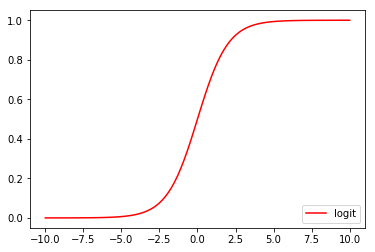

In [490]:
x = np.linspace(-10, 10, 100)
y = 1.0 / (1.0 + np.exp(-x))

plt.plot(x, y, 'r-', label='logit')
plt.legend(loc='lower right');

In [491]:
d = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv', index_col=0)

In [504]:
d.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


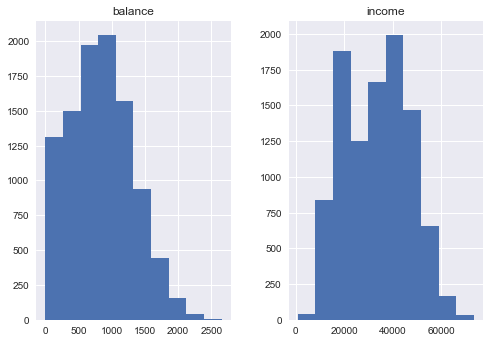

In [496]:
d.hist();

Another example:

In [466]:
# http://www.dummies.com/programming/big-data/data-science/using-logistic-regression-in-python-for-data-science/
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data[:-1,:], iris.target[:-1]

In [469]:
X

array([[ 5.1,  3.5,  1.4,  0.2],
       [ 4.9,  3. ,  1.4,  0.2],
       [ 4.7,  3.2,  1.3,  0.2],
       [ 4.6,  3.1,  1.5,  0.2],
       [ 5. ,  3.6,  1.4,  0.2],
       [ 5.4,  3.9,  1.7,  0.4],
       [ 4.6,  3.4,  1.4,  0.3],
       [ 5. ,  3.4,  1.5,  0.2],
       [ 4.4,  2.9,  1.4,  0.2],
       [ 4.9,  3.1,  1.5,  0.1],
       [ 5.4,  3.7,  1.5,  0.2],
       [ 4.8,  3.4,  1.6,  0.2],
       [ 4.8,  3. ,  1.4,  0.1],
       [ 4.3,  3. ,  1.1,  0.1],
       [ 5.8,  4. ,  1.2,  0.2],
       [ 5.7,  4.4,  1.5,  0.4],
       [ 5.4,  3.9,  1.3,  0.4],
       [ 5.1,  3.5,  1.4,  0.3],
       [ 5.7,  3.8,  1.7,  0.3],
       [ 5.1,  3.8,  1.5,  0.3],
       [ 5.4,  3.4,  1.7,  0.2],
       [ 5.1,  3.7,  1.5,  0.4],
       [ 4.6,  3.6,  1. ,  0.2],
       [ 5.1,  3.3,  1.7,  0.5],
       [ 4.8,  3.4,  1.9,  0.2],
       [ 5. ,  3. ,  1.6,  0.2],
       [ 5. ,  3.4,  1.6,  0.4],
       [ 5.2,  3.5,  1.5,  0.2],
       [ 5.2,  3.4,  1.4,  0.2],
       [ 4.7,  3.2,  1.6,  0.2],
       [ 4

In [480]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [471]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()

In [472]:
logistic.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [481]:
iris.data[-1,:]

array([ 5.9,  3. ,  5.1,  1.8])

In [487]:
logistic.predict(np.array([ 5.9,  3. ,  5.1,  1.8]))

/Users/Will/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.



array([2])

In [ ]:
logistic.predict(iris.data[-1,:]),iris.target[-1])

In [475]:
print "Probabilities for each class from 0 to 2: %s" % logistic.predict_proba(iris.data[-1,:])

Probabilities for each class from 0 to 2: [[ 0.00168787  0.28720074  0.71111138]]


/Users/Will/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.



In [476]:
iris.data[-1, :]

array([ 5.9,  3. ,  5.1,  1.8])